Задача по извлечению фич из ЭМГ.
Основная статья
https://www.researchgate.net/publication/325226027_Feature_Extraction_and_Selection_for_Myoelectric_Control_Based_on_Wearable_EMG_Sensors

1. Фичи, харктеризующие мощность и амплитуду сигнала

    Integrated Absolute Value IAV
    
    Mean Absolute Value MAV
    
    Root Mean Square RMS
    
    Variance VAR
    
    Waveform Length WL
    
    Log Detector LD
    
    Difference Absolute Mean Value DAMV
    
    Differebce Absolute Standard Deviation Value DASDV
    
    Differebce Variance Value DVARV
    
    Mean Value of Square Root MSR
    
    L-scale LS 

2. Фичи, характеризующие нелинейность и частотную информацию

    Maximum Fractal Length MFL
    
    https://www.mdpi.com/2079-3197/7/1/12/htm
    
    Detrended fluctuation analysis DFA
    
    Sample Entropy SampEn
    
    Zero Crossing ZC
    
    Slope Sign Change SSC
    
    Willison Amplitude WAMP
    
    Median Frequency MDF
    
    Mean Frequency MNF
    
3. Фичи, использующие ЭМГ как временные ряды

    Autoregressive Coefficients AR
    
    Cepstrum Coefficients CC
    
    Разного порядка 4 6 9
   
4. Уникальные

    HIST - расширение ZC и WAMP 9 data bins
    
Предложенные группы фичей
1. MAV WL ZC SSC
2. RMS AR6
3. MAV WL ZC SSC RMS AR6
4. AR4 HIST9
5. WL LD SSC AR9
6. WL SSC AR9 CC9
7. RMS VAR LD HIST9
8. WL RMS SampEn CC4

Датасеты ninaPro

Для экспериментов используем датасет ninaPro с характеристиками:

40 человек, оборудование Delsys, 17 классов движений, повторение 6 раз, частота 2000 Гц

In [2]:
import numpy as np

In [60]:
def from_mat_to_numpy(data):
    """
    Функция для формирования датасета в виде, который можно скормить классификатору.
    
    data - словарь, полученный в результате чтения .mat файла. Ключи в нём - названия, значения - значения в виде numpy массивов.
    Интересующие нас:
        emg - сигнал
        stimulus - номер выполняемого движения
        repetition - номер повтора движения
        
    Сигнал, соотв. одному и тому же повторению и движению, склеиваем в один. И сопоставляем соотв.номер движения и повторения.
    Пропускаем моменты отдыха (движение 0).
    И ещё обрезаем до одинаковой длины 5с или 12*10000 значений.
    """
    #Длина желаемой ЭМГ в секундах
    EMG_LEN = 5
    #Частота записи ЭМГ в Гц
    EMG_RATE = 2000
    #Количество каналов при записи
    EMG_CHANNELS = 12
    emg = data['emg']
    target = data['stimulus']
    repetition = data['repetition']
    
    n = emg.shape[0]
    
    curr_target = 0
    curr_rep = 0
    current_emg = np.array([])
    preprocess_data = np.zeros(shape=(17*6, EMG_LEN*EMG_RATE*EMG_CHANNELS + 2))
    index = 0
    for i in range(n):
        if target[i][0] == curr_target and repetition[i][0] == curr_rep:
            if curr_target != 0 and curr_rep != 0:
                current_emg = np.append(current_emg, emg[i])
        else:
            if curr_target != 0 and curr_rep != 0:
                diff = current_emg.shape[0] - EMG_RATE*EMG_LEN*EMG_CHANNELS
                if diff > 0:
                    begin = diff//2   
                    end = current_emg.shape[0] - diff + begin
                current_emg = current_emg[begin:end]    
                current_emg = np.append(current_emg, curr_target)
                current_emg = np.append(current_emg, curr_rep)
                preprocess_data[index] = current_emg
                index += 1
            curr_target = target[i][0]
            curr_rep = repetition[i][0]
            current_emg = emg[i]
    return preprocess_data

In [62]:
#Скрипт для обработки данных
#Проходимся по папкам с датасетом, открываем файлы, обрабатываем в нужный вид и сохраняем все npy.
def process_mat_files(path):
    file_name = "/DB2_s{n:d}/S{n:d}_E1_A1.mat"
    #processed_file_name = "/processed/S{n:d}_E1_A1"
    file_path = path + file_name
    processed_files = from_mat_to_numpy(scipy.io.loadmat(file_path.format(n=1)))
    for i in range(2, 41):
        current_file_path = file_path.format(n=i)
        current_file = scipy.io.loadmat(current_file_path)
        processed_files = np.concatenate((processed_files, from_mat_to_numpy(current_file)), axis=0)
        print(i)
    np.save(path + '/dataset', processed_files)

In [ ]:
process_mat_files("data/ninaPro/DB2")

In [63]:
from scipy import signal

In [64]:
#Реализация фильтров для ЭМГ
def notch(data, val = 50, fs = 2000):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin
    
def bandpass(data, start = 5, stop = 999, fs = 2000):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(5, bp_Hz / (fs / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

In [65]:
#Реализация фичей
import math

def integrated_absolute_value(segment):
    """
    Функция вычисления фичи IAV для конкретного сегмента.
    Площадь под кривой ЭМГ (мощность)
    """
    return sum([abs(s) for s in segment])

def mean_absolute_value(segment):
    """
    Функция вычисления фичи MAV для конкретного сегмента.
    Среднее значение сигнала по модулю.
    """
    return sum([abs(s) for s in segment])/len(segment)

def waveform_length(segment):
    """
    Функция вычисления фичи WL для конкретного сегмента.
    Суммарная длина сигнала. Сумма разностей соседних значений.
    """
    n = len(segment)
    wl = 0
    for i in range(1, n):
        wl += abs(segment[i] - segment[i-1])
    return wl

def zero_crossing(segment):
    """
    Функция вычисления фичи ZC для конкретного сегмента.
    Количество раз, когда сигнал пересекает ноль. Частотная информация.
    """
    #Можно задать e - погрешность на шумы и добавить условие |x_k - x_(k+1)| >= e.
    n = len(segment)
    zc = 0
    for i in range(n - 1):
        if segment[i] * segment[i+1] < 0:
            zc += 1
    return zc

def slope_sign_changes(segment):
    """
    Функция вычисления фичи SSC для конкретного сегмента. 
    Количество раз, когда сигнал меняет возрастание/убывание.
    Как и ZC выделяет частотную информацию. 
    """
    n = len(segment)
    ssc = 0
    for i in range(1, n-1):
        if segment[i-1] < segment[i] and segment[i] > segment[i+1] or segment[i-1] > segment[i] and segment[i] < segment[i+1]:
            ssc += 1
    return ssc

def root_mean_square(segment):
    """
    Функция вычисления фичи RMS для конкретного сегмента. 
    """
    return math.sqrt(sum([s*s for s in segment])/len(segment))

In [103]:
"""
Реализация фичи AR. Autoregressive coefficients.
Для нее не нужно выделение окон. 
Вычисляет для каждого канала коэффициенты авторегрессии. Их количество соотв. порядку регрессии order.
Для вычисления используем библиотеку nitime
"""
from nitime.algorithms.autoregressive import AR_est_LD
from sklearn.preprocessing import StandardScaler

def autoregression_coefficients(emg, order, n_channels):
    n, m = emg.shape
    scaler = StandardScaler()
    emg = scaler.fit_transform(emg)
    X = [[] for _ in range(n)]
    for i in range(n):
        for channel in range(n_channels):
            s = emg[i][channel::n_channels] 
            coef = AR_est_LD(s, order=order)[0]
            X[i].extend(coef)
    return np.array(X)

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
class random_feature_exctraction:
    """
    Класс для извлечения фичей из ЭМГ.
    Fields: 
        rate - частота ЭМГ в Гц, 
        window_size - ширина окна, по которому вычисляется фича, в мс
        n_channels - количество каналов ЭМГ
        window_begin - индекс начала окна
        features_list - список фичей, которые хотим извлечь
    """
    def __init__(self, rate, window_size, n_channels, window_begin, features_list):
        self.rate = rate
        self.window_len = int(self.rate/1000*window_size)  # Соотв. длина окна для одного канала
        self.n_channels = n_channels
        self.features_list = features_list
        self.window_begin = window_begin
    
    def exctract(self, emg):
        """
        Извлекает фичи из features_list для каждого канала из окна размера window_size с началом window_begin.
        Parameters:
            emg - numpy array of size (number_of_samples, length_of_signal)
            One row of emg:
             channel_1_value_1 channel_2_value_1 ... channel_m_value_1 channel_1value_2 ...
        Return:
            numpy array with new features
            Each row of emg is processed:
             channel_1_feature_1 channel_1_feature2 ... channel_1_feature_n channel_2_feature_1 .... channel_m_feature_n

        """
        number_of_samples, signal_len = emg.shape
        X = [[] for _ in range(number_of_samples)]
        for j in range(number_of_samples):
            feature_vector = []
            #Для каждого канала
            for channel in range(self.n_channels):
                step = self.n_channels
                #Выделяем значения одного канала с учетом желаемой частоты
                channel_emg = emg[j][channel::step]
                # Для сегмента [window_begin:window_begin+window_len] вычисляем значения фичей и записываем их в вектор
                begin = self.window_begin
                end = begin + self.window_len
                segment = channel_emg[begin:end]
                for f in self.features_list:
                    feature_vector.append(f(segment))
            X[j] = feature_vector
        return np.array(X)

In [68]:
#Загрузим весь датасет
data = np.load('data/ninaPro/DB2/dataset.npy')
print(data.shape)

(4080, 120002)


In [69]:
#Возьмем пока 7 классов 1..7
n, m = data.shape
idx_to_del = []
classes = [1, 2, 3, 4, 5, 6, 7]
for i in range(n):
    if (data[i][120000] not in classes):
        idx_to_del.append(i)
data = np.delete(data, idx_to_del, axis=0)
print(data.shape)

(1680, 120002)


In [70]:
def filter_emg(X, rate):
    """
    Функция фильтрации ЭМГ сигнала X частоты rate.
    Фильтры применяем к каждому каналу в отдельности.
    """
    n, m = X.shape
    for i in range(n):
        X_filtered = X[i]
        X_filtered = np.reshape(X_filtered, (m//12, 12))
        X_filtered = np.apply_along_axis(notch, 0, X_filtered, fs=rate)
        X_filtered = np.apply_along_axis(bandpass, 0, X_filtered, start=5, stop=rate//2 - 1, fs=rate)
        X_filtered = np.reshape(X_filtered, (1, m))
        X[i] = X_filtered

In [71]:
import random

In [81]:
def exctract_and_save(emg, features_list, feature_set_num, N=100, n_step=1, window_size=100, rate=2000, emg_len=5000, n_channels=12):
    """
    Функция извлечения фичей из ЭМГ и сохранения файлов для различных значений n.
    emg - numpy array сигнала ЭМГ,
    features_list - список фичей(в виде функций), которые хотим извлечь
    feature_set_num - номер набора фичей
    N - максимальное количество окон, по которым считаем фичи
    n_step - шаг в количестве рассм. окон
    window_size - размер окна в мс,
    rate - частота эмг в Гц
    emg_len - длина всего сигнала ЭМГ в мс, 
    n_channels - количество каналов
    """
    max_idx = rate / 1000 * (emg_len - window_size)
    X_features = np.array([[] for _ in range(emg.shape[0])])
    filename = 'data/ninaPro/DB2/featureSet{fs_num:d}/X_{i:d}_{rate:d}'
    #Для воспроизводимости фиксируем seed
    random.seed(42)
    for i in range(1, N+1):
        n = random.randint(0, max_idx-1)
        extractor = random_feature_exctraction(
            rate=rate, 
            window_size=window_size, 
            n_channels=n_channels, 
            window_begin=n, 
            features_list=features_list)
        X_features = np.concatenate((X_features, extractor.exctract(emg)), axis=1)
        if (i%n_step == 0):
            np.save(filename.format(fs_num=feature_set_num, i=i, rate=rate), X_features)
        print(i)

In [73]:
#Формируем набор 2000 Гц и вектор классов
n = data.shape[1]
X_2000 = data[:, :n-2]
y = data[:, n-2]

In [112]:
#Формируем набор 1000 Гц
#Просто берем значения 12 через 12
m, n = X_2000.shape
X_1000 = np.zeros((m, n//2))
for i in range(m):
    row = X_2000[i]
    row = np.reshape(row, (n//12, 12))
    row = row[::2][:]
    row = np.reshape(row, (1, n//2))
    X_1000[i] = row
X_1000 = np.array(X_1000)
print(X_1000.shape)

(1680, 60000)


In [75]:
filter_emg(X_2000, rate=2000)

In [113]:
filter_emg(X_1000, rate=1000)

In [ ]:
featureSet1 = [mean_absolute_value, waveform_length, zero_crossing, slope_sign_changes]
exctract_and_save(emg=X_2000, features_list=featureSet1, N=100, feature_set_num=1)

In [ ]:
exctract_and_save(X_1000, featureSet1, 1, N=100, rate=1000)

In [84]:
#Зафиксируем количество классов
N_CLASSES = 7

In [85]:
#Разделим таргет на train/test. В тест запишем каждое 6 повторение
n = y.shape[0]
test_idx = range(5, n, 6)
y_train = np.delete(y, test_idx, axis=0)
y_test = y[test_idx]

In [86]:
print(y_train.shape)
print(y_test.shape)

(1400,)
(280,)


In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [88]:
y_train = keras.utils.to_categorical(y_train - 1, num_classes=N_CLASSES)
y_test = keras.utils.to_categorical(y_test - 1, num_classes=N_CLASSES)

In [89]:
print(y_train.shape)
print(y_test.shape)

(1400, 7)
(280, 7)


In [90]:
def experiment(n, feature_set_num, rate):
    #Загружаем данные, соотв. n - количество извлечений фич из окон по 100 мс
    X = np.load('data/ninaPro/DB2/featureSet{num:d}/X_{n:d}_{r:d}.npy'.format(num=feature_set_num, n=n, r=rate))
    #Разобьем на train и test признаки аналогично таргету
    X_train = np.delete(X, test_idx, axis=0)
    X_test = X[test_idx][:]
    #Масштабируем фичи
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Создание модели
    dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(36, activation='relu', input_dim=dim))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #Обучение модели
    model.fit(X_train, y_train, epochs=150, batch_size=50)
    test_size = X_test.shape[0]
    score = model.evaluate(X_test, y_test, batch_size=test_size)
    
    #Возвращаем итоговую метрику на тесте
    return score[1]

In [97]:
#Создадим массивы для построения графиков
def arrays_for_plot(feature_set_n, rate, step):
    n_windows = list(range(1, 101, step))
    metrics = []
    for n in n_windows:
        acc = experiment(n, feature_set_n, rate=rate)
        metrics.append(acc)
    return n_windows, metrics

In [92]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\novon\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [95]:
x1_2000, y1_2000 = arrays_for_plot(feature_set_n=1, rate=2000)

Epoch 1/150
1400/1400 [==============================] - 2s 2ms/step - loss: 1.9529 - acc: 0.1450
Epoch 2/150
1400/1400 [==============================] - 0s 67us/step - loss: 1.9528 - acc: 0.1364
Epoch 3/150
1400/1400 [==============================] - 0s 63us/step - loss: 1.9499 - acc: 0.1400
Epoch 4/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.9497 - acc: 0.1414
Epoch 5/150
1400/1400 [==============================] - 0s 69us/step - loss: 1.9498 - acc: 0.1379
Epoch 6/150
1400/1400 [==============================] - 0s 69us/step - loss: 1.9485 - acc: 0.1350
Epoch 7/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.9476 - acc: 0.1414
Epoch 8/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.9469 - acc: 0.1443
Epoch 9/150
1400/1400 [==============================] - 0s 66us/step - loss: 1.9471 - acc: 0.1336
Epoch 10/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.9453 - acc: 0.1507
Epoch 11/1

1400/1400 [==============================] - 0s 63us/step - loss: 1.9182 - acc: 0.2136
Epoch 83/150
1400/1400 [==============================] - 0s 66us/step - loss: 1.9202 - acc: 0.2057
Epoch 84/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9174 - acc: 0.2071
Epoch 85/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9153 - acc: 0.2143
Epoch 86/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9155 - acc: 0.2043
Epoch 87/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9151 - acc: 0.2086
Epoch 88/150
1400/1400 [==============================] - 0s 57us/step - loss: 1.9139 - acc: 0.2243
Epoch 89/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9107 - acc: 0.2293
Epoch 90/150
1400/1400 [==============================] - 0s 59us/step - loss: 1.9125 - acc: 0.2143
Epoch 91/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9108 - acc: 0.2207
Epoch 92/150


1400/1400 [==============================] - 0s 84us/step - loss: 1.9296 - acc: 0.2021
Epoch 14/150
1400/1400 [==============================] - 0s 72us/step - loss: 1.9293 - acc: 0.2050
Epoch 15/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.9264 - acc: 0.2057
Epoch 16/150
1400/1400 [==============================] - 0s 85us/step - loss: 1.9235 - acc: 0.2150
Epoch 17/150
1400/1400 [==============================] - 0s 77us/step - loss: 1.9244 - acc: 0.1936
Epoch 18/150
1400/1400 [==============================] - 0s 72us/step - loss: 1.9208 - acc: 0.1986
Epoch 19/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.9165 - acc: 0.2179
Epoch 20/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.9166 - acc: 0.1979
Epoch 21/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.9105 - acc: 0.2314
Epoch 22/150
1400/1400 [==============================] - 0s 78us/step - loss: 1.9143 - acc: 0.2236
Epoch 23/15

1400/1400 [==============================] - 0s 75us/step - loss: 1.6283 - acc: 0.3593
Epoch 95/150
1400/1400 [==============================] - 0s 83us/step - loss: 1.6168 - acc: 0.3657
Epoch 96/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.6085 - acc: 0.3693
Epoch 97/150
1400/1400 [==============================] - 0s 82us/step - loss: 1.6249 - acc: 0.3729
Epoch 98/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.6217 - acc: 0.3700
Epoch 99/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.5961 - acc: 0.3707
Epoch 100/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.5997 - acc: 0.3857
Epoch 101/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.6059 - acc: 0.3657
Epoch 102/150
1400/1400 [==============================] - 0s 114us/step - loss: 1.6055 - acc: 0.3814
Epoch 103/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.5906 - acc: 0.3800
Epo

1400/1400 [==============================] - 0s 115us/step - loss: 1.8793 - acc: 0.2393
Epoch 25/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.8729 - acc: 0.2479
Epoch 26/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.8747 - acc: 0.2379
Epoch 27/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.8711 - acc: 0.2386
Epoch 28/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8677 - acc: 0.2514
Epoch 29/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.8565 - acc: 0.2607
Epoch 30/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.8518 - acc: 0.2700
Epoch 31/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.8442 - acc: 0.2764
Epoch 32/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8427 - acc: 0.2607
Epoch 33/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.8310 - acc: 0.2586
Epoc

1400/1400 [==============================] - 0s 130us/step - loss: 1.4714 - acc: 0.4493
Epoch 106/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.4675 - acc: 0.4336
Epoch 107/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.4575 - acc: 0.4379
Epoch 108/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.4369 - acc: 0.4486
Epoch 109/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.4527 - acc: 0.4350 0s - loss: 1.4708 - acc: 0.427
Epoch 110/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.4530 - acc: 0.4393
Epoch 111/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.4384 - acc: 0.4329
Epoch 112/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.4308 - acc: 0.4379
Epoch 113/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.4420 - acc: 0.4393
Epoch 114/150
1400/1400 [==============================] - 0s 112

1400/1400 [==============================] - 0s 189us/step - loss: 1.7477 - acc: 0.3136
Epoch 35/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.7435 - acc: 0.3064
Epoch 36/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.7360 - acc: 0.3221
Epoch 37/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.7317 - acc: 0.3136
Epoch 38/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.7125 - acc: 0.3471
Epoch 39/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.7291 - acc: 0.2936
Epoch 40/150
1400/1400 [==============================] - 0s 112us/step - loss: 1.7069 - acc: 0.3243
Epoch 41/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.6899 - acc: 0.3414
Epoch 42/150
1400/1400 [==============================] - 0s 115us/step - loss: 1.6954 - acc: 0.3336
Epoch 43/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.6828 - acc: 0.3357
Epo

1400/1400 [==============================] - 0s 135us/step - loss: 1.2735 - acc: 0.4936
Epoch 116/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.2980 - acc: 0.4914
Epoch 117/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.2637 - acc: 0.5064
Epoch 118/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.2490 - acc: 0.5079
Epoch 119/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.2658 - acc: 0.5136
Epoch 120/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.2565 - acc: 0.5107
Epoch 121/150
1400/1400 [==============================] - 0s 120us/step - loss: 1.2540 - acc: 0.5257
Epoch 122/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.2311 - acc: 0.5300
Epoch 123/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.2474 - acc: 0.5157
Epoch 124/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.2403 - acc: 0

1400/1400 [==============================] - 0s 121us/step - loss: 1.6815 - acc: 0.3486
Epoch 46/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.6819 - acc: 0.3207
Epoch 47/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.6581 - acc: 0.3264
Epoch 48/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.6660 - acc: 0.3286
Epoch 49/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.6456 - acc: 0.3464
Epoch 50/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.6469 - acc: 0.3386
Epoch 51/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.6422 - acc: 0.3493
Epoch 52/150
1400/1400 [==============================] - 0s 115us/step - loss: 1.6369 - acc: 0.3686
Epoch 53/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.6280 - acc: 0.3443
Epoch 54/150
1400/1400 [==============================] - 0s 112us/step - loss: 1.6107 - acc: 0.3393
Epo

Epoch 126/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.2528 - acc: 0.5093
Epoch 127/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.2607 - acc: 0.4957
Epoch 128/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.2474 - acc: 0.5000
Epoch 129/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.2501 - acc: 0.5000
Epoch 130/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.2429 - acc: 0.5129
Epoch 131/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.2269 - acc: 0.5214
Epoch 132/150
1400/1400 [==============================] - 0s 120us/step - loss: 1.2378 - acc: 0.5150
Epoch 133/150
1400/1400 [==============================] - 0s 120us/step - loss: 1.2418 - acc: 0.5029
Epoch 134/150
1400/1400 [==============================] - 0s 139us/step - loss: 1.2318 - acc: 0.5129
Epoch 135/150
1400/1400 [==============================] - 0s 125us/step - loss: 1

1400/1400 [==============================] - 0s 128us/step - loss: 1.6382 - acc: 0.3507
Epoch 57/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.6218 - acc: 0.3507
Epoch 58/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.6222 - acc: 0.3636
Epoch 59/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.6090 - acc: 0.3607
Epoch 60/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.6117 - acc: 0.3671
Epoch 61/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.5912 - acc: 0.3700
Epoch 62/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.6017 - acc: 0.3650
Epoch 63/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.5829 - acc: 0.3757
Epoch 64/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5723 - acc: 0.3771
Epoch 65/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5762 - acc: 0.3736
Epo

1400/1400 [==============================] - 0s 138us/step - loss: 1.1349 - acc: 0.5621
Epoch 137/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.1287 - acc: 0.5764
Epoch 138/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.1187 - acc: 0.5550
Epoch 139/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.1175 - acc: 0.5693
Epoch 140/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.1088 - acc: 0.5671
Epoch 141/150
1400/1400 [==============================] - 0s 127us/step - loss: 1.1047 - acc: 0.5643
Epoch 142/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.0940 - acc: 0.5679
Epoch 143/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.0826 - acc: 0.5814
Epoch 144/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.0932 - acc: 0.5829
Epoch 145/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.0877 - acc: 0

1400/1400 [==============================] - 0s 142us/step - loss: 1.3237 - acc: 0.4864
Epoch 67/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.3272 - acc: 0.4914
Epoch 68/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.3081 - acc: 0.4914
Epoch 69/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.2950 - acc: 0.5029
Epoch 70/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.2932 - acc: 0.5079
Epoch 71/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.2832 - acc: 0.5150
Epoch 72/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.2865 - acc: 0.5207
Epoch 73/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.2593 - acc: 0.5164
Epoch 74/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.2729 - acc: 0.5307
Epoch 75/150
1400/1400 [==============================] - 0s 136us/step - loss: 1.2408 - acc: 0.5371
Epo

1400/1400 [==============================] - 0s 139us/step - loss: 0.7352 - acc: 0.7279
Epoch 147/150
1400/1400 [==============================] - 0s 135us/step - loss: 0.7371 - acc: 0.7336
Epoch 148/150
1400/1400 [==============================] - 0s 143us/step - loss: 0.7293 - acc: 0.7364
Epoch 149/150
1400/1400 [==============================] - 0s 128us/step - loss: 0.7189 - acc: 0.7371
Epoch 150/150
280/280 [==============================] - 1s 4ms/step
Epoch 1/150
1400/1400 [==============================] - 3s 2ms/step - loss: 1.9613 - acc: 0.1664
Epoch 2/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.9377 - acc: 0.1764
Epoch 3/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.9347 - acc: 0.1836
Epoch 4/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.9302 - acc: 0.1936
Epoch 5/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.9269 - acc: 0.1979
Epoch 6/150
1400/1400 [================

1400/1400 [==============================] - 0s 133us/step - loss: 1.2725 - acc: 0.5086
Epoch 77/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.2979 - acc: 0.5007
Epoch 78/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.2841 - acc: 0.5150
Epoch 79/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.2706 - acc: 0.5093
Epoch 80/150
1400/1400 [==============================] - 0s 127us/step - loss: 1.2805 - acc: 0.5014
Epoch 81/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.2685 - acc: 0.5207
Epoch 82/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.2550 - acc: 0.5286
Epoch 83/150
1400/1400 [==============================] - 0s 136us/step - loss: 1.2504 - acc: 0.5207
Epoch 84/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.2462 - acc: 0.5329
Epoch 85/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.2130 - acc: 0.5521
Epo

1400/1400 [==============================] - 0s 129us/step - loss: 1.9342 - acc: 0.1821
Epoch 7/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.9290 - acc: 0.1986
Epoch 8/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.9270 - acc: 0.1843
Epoch 9/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.9227 - acc: 0.2243
Epoch 10/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.9237 - acc: 0.2064
Epoch 11/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.9153 - acc: 0.2221
Epoch 12/150
1400/1400 [==============================] - 0s 120us/step - loss: 1.9064 - acc: 0.2429
Epoch 13/150
1400/1400 [==============================] - 0s 119us/step - loss: 1.9094 - acc: 0.2500
Epoch 14/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.9073 - acc: 0.2329
Epoch 15/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.8954 - acc: 0.2507
Epoch 

1400/1400 [==============================] - 0s 125us/step - loss: 1.2358 - acc: 0.5507
Epoch 88/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.1957 - acc: 0.5550
Epoch 89/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.2050 - acc: 0.5529
Epoch 90/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.1977 - acc: 0.5643
Epoch 91/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.1785 - acc: 0.5700
Epoch 92/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.1849 - acc: 0.5636
Epoch 93/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.1533 - acc: 0.5800
Epoch 94/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.1436 - acc: 0.5764
Epoch 95/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.1587 - acc: 0.5814
Epoch 96/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.1396 - acc: 0.5686
Epo

1400/1400 [==============================] - 0s 171us/step - loss: 1.8804 - acc: 0.2579
Epoch 18/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.8765 - acc: 0.2436
Epoch 19/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.8655 - acc: 0.2486
Epoch 20/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.8548 - acc: 0.2579
Epoch 21/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.8503 - acc: 0.2443
Epoch 22/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.8359 - acc: 0.2636
Epoch 23/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.8282 - acc: 0.2829
Epoch 24/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.8221 - acc: 0.2814
Epoch 25/150
1400/1400 [==============================] - 0s 144us/step - loss: 1.8149 - acc: 0.2786
Epoch 26/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7991 - acc: 0.2771
Epo

Epoch 98/150
1400/1400 [==============================] - 0s 151us/step - loss: 0.9728 - acc: 0.6450
Epoch 99/150
1400/1400 [==============================] - 0s 134us/step - loss: 0.9520 - acc: 0.6393
Epoch 100/150
1400/1400 [==============================] - 0s 140us/step - loss: 0.9368 - acc: 0.6507
Epoch 101/150
1400/1400 [==============================] - 0s 154us/step - loss: 0.9071 - acc: 0.6671 0s - loss: 0.8984 - acc: 0.673
Epoch 102/150
1400/1400 [==============================] - 0s 136us/step - loss: 0.9029 - acc: 0.6729
Epoch 103/150
1400/1400 [==============================] - 0s 139us/step - loss: 0.8895 - acc: 0.6664
Epoch 104/150
1400/1400 [==============================] - 0s 143us/step - loss: 0.8733 - acc: 0.6850
Epoch 105/150
1400/1400 [==============================] - 0s 145us/step - loss: 0.8555 - acc: 0.6893
Epoch 106/150
1400/1400 [==============================] - 0s 136us/step - loss: 0.8652 - acc: 0.6800
Epoch 107/150
1400/1400 [============================

1400/1400 [==============================] - 0s 167us/step - loss: 1.5494 - acc: 0.4093
Epoch 28/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.5244 - acc: 0.4229
Epoch 29/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.5259 - acc: 0.4179
Epoch 30/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.5209 - acc: 0.4300
Epoch 31/150
1400/1400 [==============================] - 0s 144us/step - loss: 1.5083 - acc: 0.4279
Epoch 32/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4732 - acc: 0.4450
Epoch 33/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.4608 - acc: 0.4514
Epoch 34/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4529 - acc: 0.4414
Epoch 35/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.4262 - acc: 0.4579
Epoch 36/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.4130 - acc: 0.4564
Epo

1400/1400 [==============================] - 0s 145us/step - loss: 0.6708 - acc: 0.7621
Epoch 108/150
1400/1400 [==============================] - 0s 151us/step - loss: 0.6757 - acc: 0.7550
Epoch 109/150
1400/1400 [==============================] - ETA: 0s - loss: 0.6621 - acc: 0.765 - 0s 143us/step - loss: 0.6751 - acc: 0.7579
Epoch 110/150
1400/1400 [==============================] - 0s 142us/step - loss: 0.6746 - acc: 0.7686
Epoch 111/150
1400/1400 [==============================] - 0s 154us/step - loss: 0.6329 - acc: 0.7700
Epoch 112/150
1400/1400 [==============================] - 0s 140us/step - loss: 0.6674 - acc: 0.7586
Epoch 113/150
1400/1400 [==============================] - 0s 162us/step - loss: 0.6237 - acc: 0.7750
Epoch 114/150
1400/1400 [==============================] - 0s 146us/step - loss: 0.6109 - acc: 0.7886
Epoch 115/150
1400/1400 [==============================] - 0s 150us/step - loss: 0.6397 - acc: 0.7721
Epoch 116/150
1400/1400 [==============================] -

1400/1400 [==============================] - 0s 148us/step - loss: 1.5233 - acc: 0.3936
Epoch 37/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.5326 - acc: 0.3879
Epoch 38/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5022 - acc: 0.4071
Epoch 39/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.4750 - acc: 0.4079
Epoch 40/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.4662 - acc: 0.4321
Epoch 41/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.4636 - acc: 0.4164
Epoch 42/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.4625 - acc: 0.4207
Epoch 43/150
1400/1400 [==============================] - 0s 144us/step - loss: 1.4475 - acc: 0.4029
Epoch 44/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.4384 - acc: 0.4264
Epoch 45/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.4115 - acc: 0.4307
Epo

1400/1400 [==============================] - 0s 215us/step - loss: 0.7975 - acc: 0.7057
Epoch 117/150
1400/1400 [==============================] - 0s 154us/step - loss: 0.8070 - acc: 0.6993
Epoch 118/150
1400/1400 [==============================] - 0s 146us/step - loss: 0.7979 - acc: 0.7021
Epoch 119/150
1400/1400 [==============================] - 0s 156us/step - loss: 0.7840 - acc: 0.7057
Epoch 120/150
1400/1400 [==============================] - 0s 146us/step - loss: 0.7966 - acc: 0.6893
Epoch 121/150
1400/1400 [==============================] - 0s 150us/step - loss: 0.7681 - acc: 0.7129
Epoch 122/150
1400/1400 [==============================] - 0s 153us/step - loss: 0.7503 - acc: 0.7043
Epoch 123/150
1400/1400 [==============================] - 0s 147us/step - loss: 0.7517 - acc: 0.7193
Epoch 124/150
1400/1400 [==============================] - 0s 155us/step - loss: 0.7491 - acc: 0.7236
Epoch 125/150
1400/1400 [==============================] - 0s 142us/step - loss: 0.7624 - acc: 0

1400/1400 [==============================] - 0s 160us/step - loss: 1.4341 - acc: 0.4364
Epoch 47/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.4058 - acc: 0.4500
Epoch 48/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.4199 - acc: 0.4329
Epoch 49/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.4278 - acc: 0.4407
Epoch 50/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.4067 - acc: 0.4343
Epoch 51/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.3766 - acc: 0.4521
Epoch 52/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.3848 - acc: 0.4671
Epoch 53/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.3792 - acc: 0.4579
Epoch 54/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.3699 - acc: 0.4729
Epoch 55/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.3658 - acc: 0.4764
Epo

Epoch 127/150
1400/1400 [==============================] - 0s 170us/step - loss: 0.7064 - acc: 0.7443
Epoch 128/150
1400/1400 [==============================] - 0s 160us/step - loss: 0.7194 - acc: 0.7486
Epoch 129/150
1400/1400 [==============================] - 0s 165us/step - loss: 0.6950 - acc: 0.7386
Epoch 130/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.7136 - acc: 0.7379
Epoch 131/150
1400/1400 [==============================] - 0s 151us/step - loss: 0.6959 - acc: 0.7529
Epoch 132/150
1400/1400 [==============================] - 0s 155us/step - loss: 0.6905 - acc: 0.7543
Epoch 133/150
1400/1400 [==============================] - 0s 153us/step - loss: 0.6921 - acc: 0.7457
Epoch 134/150
1400/1400 [==============================] - 0s 161us/step - loss: 0.6750 - acc: 0.7429
Epoch 135/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.6593 - acc: 0.7593
Epoch 136/150
1400/1400 [==============================] - 0s 158us/step - loss: 0

1400/1400 [==============================] - 0s 177us/step - loss: 1.3331 - acc: 0.4971
Epoch 58/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.3216 - acc: 0.4993
Epoch 59/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.3147 - acc: 0.5150
Epoch 60/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.3040 - acc: 0.5186
Epoch 61/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.2884 - acc: 0.5164
Epoch 62/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.2773 - acc: 0.5300
Epoch 63/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.2591 - acc: 0.5421
Epoch 64/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.2509 - acc: 0.5364
Epoch 65/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.2403 - acc: 0.5436
Epoch 66/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.2164 - acc: 0.5600
Epo

1400/1400 [==============================] - 0s 160us/step - loss: 0.5162 - acc: 0.8300
Epoch 138/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.5167 - acc: 0.8300
Epoch 139/150
1400/1400 [==============================] - 0s 150us/step - loss: 0.5424 - acc: 0.8164
Epoch 140/150
1400/1400 [==============================] - 0s 172us/step - loss: 0.5120 - acc: 0.8271
Epoch 141/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.4752 - acc: 0.8486
Epoch 142/150
1400/1400 [==============================] - 0s 177us/step - loss: 0.4822 - acc: 0.8386
Epoch 143/150
1400/1400 [==============================] - 0s 155us/step - loss: 0.4629 - acc: 0.8593
Epoch 144/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.4759 - acc: 0.8400
Epoch 145/150
1400/1400 [==============================] - 0s 191us/step - loss: 0.4480 - acc: 0.8579
Epoch 146/150
1400/1400 [==============================] - 0s 166us/step - loss: 0.4392 - acc: 0

1400/1400 [==============================] - 0s 186us/step - loss: 1.0283 - acc: 0.6021
Epoch 68/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.0501 - acc: 0.6079
Epoch 69/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.0102 - acc: 0.6271
Epoch 70/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.0119 - acc: 0.6314
Epoch 71/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.9896 - acc: 0.6414
Epoch 72/150
1400/1400 [==============================] - 0s 176us/step - loss: 0.9861 - acc: 0.6257
Epoch 73/150
1400/1400 [==============================] - 0s 161us/step - loss: 0.9751 - acc: 0.6393
Epoch 74/150
1400/1400 [==============================] - 0s 172us/step - loss: 0.9545 - acc: 0.6529
Epoch 75/150
1400/1400 [==============================] - 0s 162us/step - loss: 0.9629 - acc: 0.6286
Epoch 76/150
1400/1400 [==============================] - 0s 177us/step - loss: 0.9564 - acc: 0.6314
Epo

1400/1400 [==============================] - 0s 182us/step - loss: 0.4461 - acc: 0.8400
Epoch 148/150
1400/1400 [==============================] - 0s 176us/step - loss: 0.4133 - acc: 0.8571
Epoch 149/150
1400/1400 [==============================] - 0s 188us/step - loss: 0.4107 - acc: 0.8550
Epoch 150/150
280/280 [==============================] - 1s 4ms/step
Epoch 1/150
1400/1400 [==============================] - 3s 2ms/step - loss: 1.9458 - acc: 0.1557
Epoch 2/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.9325 - acc: 0.2014
Epoch 3/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.9239 - acc: 0.1886
Epoch 4/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.9137 - acc: 0.2014
Epoch 5/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.9007 - acc: 0.2150
Epoch 6/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.8849 - acc: 0.2257
Epoch 7/150
1400/1400 [==================

1400/1400 [==============================] - 0s 186us/step - loss: 0.9838 - acc: 0.6464
Epoch 78/150
1400/1400 [==============================] - 0s 178us/step - loss: 0.9803 - acc: 0.6421
Epoch 79/150
1400/1400 [==============================] - 0s 177us/step - loss: 0.9562 - acc: 0.6621
Epoch 80/150
1400/1400 [==============================] - 0s 175us/step - loss: 0.9625 - acc: 0.6607
Epoch 81/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.9639 - acc: 0.6543
Epoch 82/150
1400/1400 [==============================] - 0s 172us/step - loss: 0.9198 - acc: 0.6636
Epoch 83/150
1400/1400 [==============================] - 0s 177us/step - loss: 0.9067 - acc: 0.6871
Epoch 84/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.9313 - acc: 0.6779
Epoch 85/150
1400/1400 [==============================] - 0s 162us/step - loss: 0.8971 - acc: 0.6779
Epoch 86/150
1400/1400 [==============================] - 0s 176us/step - loss: 0.9008 - acc: 0.6836
Epo

1400/1400 [==============================] - 0s 188us/step - loss: 1.8697 - acc: 0.2393
Epoch 8/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.8560 - acc: 0.2414
Epoch 9/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.8408 - acc: 0.2671
Epoch 10/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.8266 - acc: 0.2643
Epoch 11/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.8059 - acc: 0.2807
Epoch 12/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.7960 - acc: 0.2671
Epoch 13/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.7684 - acc: 0.2907
Epoch 14/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.7616 - acc: 0.3157
Epoch 15/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.7407 - acc: 0.3157
Epoch 16/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.7304 - acc: 0.3136
Epoch

1400/1400 [==============================] - 0s 192us/step - loss: 0.7739 - acc: 0.7371
Epoch 89/150
1400/1400 [==============================] - 0s 175us/step - loss: 0.7345 - acc: 0.7571
Epoch 90/150
1400/1400 [==============================] - 0s 189us/step - loss: 0.7540 - acc: 0.7379
Epoch 91/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.7480 - acc: 0.7371
Epoch 92/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.7092 - acc: 0.7550
Epoch 93/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.7123 - acc: 0.7736
Epoch 94/150
1400/1400 [==============================] - 0s 197us/step - loss: 0.7140 - acc: 0.7593
Epoch 95/150
1400/1400 [==============================] - 0s 168us/step - loss: 0.7129 - acc: 0.7586
Epoch 96/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.7220 - acc: 0.7493
Epoch 97/150
1400/1400 [==============================] - 0s 180us/step - loss: 0.6896 - acc: 0.7693
Epo

1400/1400 [==============================] - 0s 189us/step - loss: 1.6330 - acc: 0.3736
Epoch 18/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.6086 - acc: 0.3779
Epoch 19/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.5895 - acc: 0.3957
Epoch 20/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.5738 - acc: 0.3900
Epoch 21/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.5670 - acc: 0.3900
Epoch 22/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.5384 - acc: 0.3929
Epoch 23/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.5161 - acc: 0.4036
Epoch 24/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.5212 - acc: 0.4029
Epoch 25/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.4813 - acc: 0.4386
Epoch 26/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.4874 - acc: 0.4164
Epo

1400/1400 [==============================] - 0s 205us/step - loss: 0.6806 - acc: 0.7550
Epoch 99/150
1400/1400 [==============================] - 0s 199us/step - loss: 0.6901 - acc: 0.7571
Epoch 100/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.6919 - acc: 0.7450
Epoch 101/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.7103 - acc: 0.7379
Epoch 102/150
1400/1400 [==============================] - 0s 190us/step - loss: 0.6680 - acc: 0.7593
Epoch 103/150
1400/1400 [==============================] - 0s 190us/step - loss: 0.6913 - acc: 0.7429
Epoch 104/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.6545 - acc: 0.7693
Epoch 105/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.6357 - acc: 0.7807
Epoch 106/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.6401 - acc: 0.7686
Epoch 107/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.6133 - acc: 0.

1400/1400 [==============================] - 0s 198us/step - loss: 1.6089 - acc: 0.3779
Epoch 29/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.6015 - acc: 0.3829
Epoch 30/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.5745 - acc: 0.3879
Epoch 31/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.5564 - acc: 0.4064
Epoch 32/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.5394 - acc: 0.4207
Epoch 33/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.5434 - acc: 0.4071
Epoch 34/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.5085 - acc: 0.4236
Epoch 35/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.5034 - acc: 0.4307
Epoch 36/150
1400/1400 [==============================] - 0s 218us/step - loss: 1.5090 - acc: 0.4214
Epoch 37/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.4629 - acc: 0.4507
Epo

1400/1400 [==============================] - 0s 188us/step - loss: 0.6411 - acc: 0.7629
Epoch 109/150
1400/1400 [==============================] - 0s 195us/step - loss: 0.6251 - acc: 0.7721
Epoch 110/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.5970 - acc: 0.7950
Epoch 111/150
1400/1400 [==============================] - 0s 200us/step - loss: 0.6032 - acc: 0.7829
Epoch 112/150
1400/1400 [==============================] - 0s 190us/step - loss: 0.6192 - acc: 0.7736
Epoch 113/150
1400/1400 [==============================] - 0s 199us/step - loss: 0.5943 - acc: 0.7900
Epoch 114/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.5872 - acc: 0.7929
Epoch 115/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.5969 - acc: 0.7871
Epoch 116/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.5762 - acc: 0.7907
Epoch 117/150
1400/1400 [==============================] - 0s 188us/step - loss: 0.5649 - acc: 0

1400/1400 [==============================] - 0s 205us/step - loss: 1.3990 - acc: 0.4557
Epoch 39/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.3814 - acc: 0.4736
Epoch 40/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.3677 - acc: 0.4700
Epoch 41/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.3568 - acc: 0.4779
Epoch 42/150
1400/1400 [==============================] - 0s 195us/step - loss: 1.3324 - acc: 0.4957
Epoch 43/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.3427 - acc: 0.4857
Epoch 44/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.3432 - acc: 0.4743
Epoch 45/150
1400/1400 [==============================] - 0s 206us/step - loss: 1.3320 - acc: 0.4879
Epoch 46/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.2954 - acc: 0.5086
Epoch 47/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.3047 - acc: 0.5043
Epo

1400/1400 [==============================] - 0s 209us/step - loss: 0.5915 - acc: 0.7714
Epoch 120/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.5405 - acc: 0.8186
Epoch 121/150
1400/1400 [==============================] - 0s 201us/step - loss: 0.5519 - acc: 0.7964
Epoch 122/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.5275 - acc: 0.8186
Epoch 123/150
1400/1400 [==============================] - 0s 200us/step - loss: 0.5496 - acc: 0.7993
Epoch 124/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.5290 - acc: 0.8064
Epoch 125/150
1400/1400 [==============================] - 0s 207us/step - loss: 0.5335 - acc: 0.8050
Epoch 126/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.4957 - acc: 0.8179
Epoch 127/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.5482 - acc: 0.8071
Epoch 128/150
1400/1400 [==============================] - 0s 191us/step - loss: 0.5036 - acc: 0

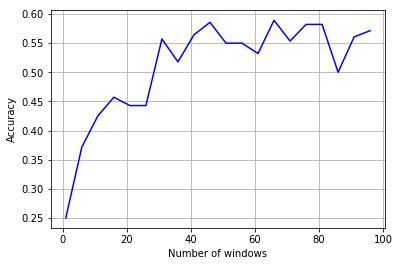

In [96]:
pylab.grid(True)
pylab.plot(x1_2000, y1_2000, 'b-')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')

In [115]:
x1_1000, y1_1000 = arrays_for_plot(feature_set_n=1, rate=1000, step=5)

Epoch 1/150
1400/1400 [==============================] - 7s 5ms/step - loss: 1.9584 - acc: 0.1379
Epoch 2/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.9558 - acc: 0.1443
Epoch 3/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.9514 - acc: 0.1643
Epoch 4/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.9491 - acc: 0.1471
Epoch 5/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.9471 - acc: 0.1536
Epoch 6/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.9467 - acc: 0.1557
Epoch 7/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.9449 - acc: 0.1557
Epoch 8/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.9439 - acc: 0.1593
Epoch 9/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.9449 - acc: 0.1657
Epoch 10/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.9411 - acc: 0.1643
E

1400/1400 [==============================] - 0s 109us/step - loss: 1.8648 - acc: 0.2350
Epoch 83/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.8633 - acc: 0.2429
Epoch 84/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8591 - acc: 0.2379
Epoch 85/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.8587 - acc: 0.2386
Epoch 86/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.8579 - acc: 0.2450
Epoch 87/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.8536 - acc: 0.2329
Epoch 88/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.8530 - acc: 0.2286
Epoch 89/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.8541 - acc: 0.2364
Epoch 90/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.8545 - acc: 0.2400
Epoch 91/150
1400/1400 [==============================] - 0s 115us/step - loss: 1.8461 - acc: 0.2471
Epo

1400/1400 [==============================] - 0s 91us/step - loss: 1.9326 - acc: 0.1893
Epoch 13/150
1400/1400 [==============================] - 0s 93us/step - loss: 1.9343 - acc: 0.1743
Epoch 14/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.9313 - acc: 0.1943
Epoch 15/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.9339 - acc: 0.1814
Epoch 16/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.9335 - acc: 0.1929
Epoch 17/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.9313 - acc: 0.1879
Epoch 18/150
1400/1400 [==============================] - 0s 85us/step - loss: 1.9321 - acc: 0.1786
Epoch 19/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.9308 - acc: 0.1900
Epoch 20/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.9305 - acc: 0.1929
Epoch 21/150
1400/1400 [==============================] - 0s 85us/step - loss: 1.9301 - acc: 0.1936
Epoch 22/150


1400/1400 [==============================] - 0s 95us/step - loss: 1.7376 - acc: 0.3129
Epoch 93/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.7370 - acc: 0.3014
Epoch 94/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7429 - acc: 0.3179
Epoch 95/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.7301 - acc: 0.3243
Epoch 96/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.7240 - acc: 0.3093
Epoch 97/150
1400/1400 [==============================] - 0s 93us/step - loss: 1.7142 - acc: 0.3293
Epoch 98/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.7116 - acc: 0.3171
Epoch 99/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.7344 - acc: 0.3000
Epoch 100/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.7138 - acc: 0.3200
Epoch 101/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.7190 - acc: 0.3143
Epoch 102

1400/1400 [==============================] - 0s 227us/step - loss: 1.9206 - acc: 0.1950
Epoch 23/150
1400/1400 [==============================] - 0s 209us/step - loss: 1.9178 - acc: 0.2100
Epoch 24/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.9146 - acc: 0.2121
Epoch 25/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.9150 - acc: 0.2057
Epoch 26/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.9128 - acc: 0.2129
Epoch 27/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.9117 - acc: 0.2029
Epoch 28/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9065 - acc: 0.2186
Epoch 29/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.9081 - acc: 0.2050
Epoch 30/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.9077 - acc: 0.1993
Epoch 31/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.9037 - acc: 0.2164
Epo

1400/1400 [==============================] - 0s 194us/step - loss: 1.5809 - acc: 0.3814
Epoch 104/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.5847 - acc: 0.3836
Epoch 105/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5794 - acc: 0.3979
Epoch 106/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.5921 - acc: 0.3864
Epoch 107/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5650 - acc: 0.3893
Epoch 108/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.5666 - acc: 0.3850
Epoch 109/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5597 - acc: 0.4064
Epoch 110/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.5542 - acc: 0.4036
Epoch 111/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.5500 - acc: 0.4121
Epoch 112/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.5446 - acc: 0

1400/1400 [==============================] - 0s 198us/step - loss: 1.8979 - acc: 0.2100
Epoch 34/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.8989 - acc: 0.2129
Epoch 35/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.8869 - acc: 0.2450
Epoch 36/150
1400/1400 [==============================] - 0s 230us/step - loss: 1.8842 - acc: 0.2171
Epoch 37/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.8900 - acc: 0.2286
Epoch 38/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.8793 - acc: 0.2379
Epoch 39/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.8774 - acc: 0.2207
Epoch 40/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.8694 - acc: 0.2343
Epoch 41/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.8719 - acc: 0.2321
Epoch 42/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.8638 - acc: 0.2414
Epo

1400/1400 [==============================] - 0s 146us/step - loss: 1.3889 - acc: 0.4429
Epoch 115/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.3987 - acc: 0.4279
Epoch 116/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.3856 - acc: 0.4443
Epoch 117/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.3890 - acc: 0.4329
Epoch 118/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.3968 - acc: 0.4493
Epoch 119/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.3824 - acc: 0.4557
Epoch 120/150
1400/1400 [==============================] - 0s 227us/step - loss: 1.3831 - acc: 0.4464
Epoch 121/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.3596 - acc: 0.4457
Epoch 122/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.3567 - acc: 0.4493
Epoch 123/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.3565 - acc: 0

1400/1400 [==============================] - 0s 171us/step - loss: 1.6759 - acc: 0.3600
Epoch 45/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.6635 - acc: 0.3500
Epoch 46/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.6695 - acc: 0.3386
Epoch 47/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.6482 - acc: 0.3500
Epoch 48/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.6396 - acc: 0.3514
Epoch 49/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.6280 - acc: 0.3693
Epoch 50/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.6248 - acc: 0.3629
Epoch 51/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.6131 - acc: 0.3657
Epoch 52/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.6059 - acc: 0.3579
Epoch 53/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.5952 - acc: 0.3771
Epo

1400/1400 [==============================] - 0s 170us/step - loss: 1.1327 - acc: 0.5607
Epoch 125/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.1320 - acc: 0.5600
Epoch 126/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.1288 - acc: 0.5636
Epoch 127/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.1424 - acc: 0.5593
Epoch 128/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.1300 - acc: 0.5679
Epoch 129/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.1194 - acc: 0.5757
Epoch 130/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.0857 - acc: 0.5771
Epoch 131/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.0913 - acc: 0.5900
Epoch 132/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.1008 - acc: 0.5800
Epoch 133/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.0668 - acc: 0

1400/1400 [==============================] - 0s 158us/step - loss: 1.4921 - acc: 0.3964
Epoch 55/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.4664 - acc: 0.3986
Epoch 56/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.4528 - acc: 0.4293
Epoch 57/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.4526 - acc: 0.4207
Epoch 58/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.4472 - acc: 0.4121
Epoch 59/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.4470 - acc: 0.4171
Epoch 60/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.4149 - acc: 0.4264
Epoch 61/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.4210 - acc: 0.4243
Epoch 62/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.4181 - acc: 0.4250
Epoch 63/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.4041 - acc: 0.4550
Epo

1400/1400 [==============================] - 0s 155us/step - loss: 0.9638 - acc: 0.6371
Epoch 135/150
1400/1400 [==============================] - 0s 145us/step - loss: 0.9443 - acc: 0.6307
Epoch 136/150
1400/1400 [==============================] - 0s 152us/step - loss: 0.9477 - acc: 0.6464
Epoch 137/150
1400/1400 [==============================] - 0s 153us/step - loss: 0.9255 - acc: 0.6443
Epoch 138/150
1400/1400 [==============================] - 0s 150us/step - loss: 0.9225 - acc: 0.6557
Epoch 139/150
1400/1400 [==============================] - 0s 152us/step - loss: 0.9363 - acc: 0.6414
Epoch 140/150
1400/1400 [==============================] - 0s 150us/step - loss: 0.8998 - acc: 0.6664
Epoch 141/150
1400/1400 [==============================] - 0s 152us/step - loss: 0.9066 - acc: 0.6443
Epoch 142/150
1400/1400 [==============================] - 0s 154us/step - loss: 0.9234 - acc: 0.6379
Epoch 143/150
1400/1400 [==============================] - 0s 153us/step - loss: 0.9133 - acc: 0

1400/1400 [==============================] - 0s 148us/step - loss: 1.5407 - acc: 0.4236
Epoch 65/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5236 - acc: 0.4236
Epoch 66/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.5268 - acc: 0.4229
Epoch 67/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.5215 - acc: 0.4307
Epoch 68/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.5101 - acc: 0.4286
Epoch 69/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.4872 - acc: 0.4536
Epoch 70/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.4836 - acc: 0.4429
Epoch 71/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.4804 - acc: 0.4571
Epoch 72/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.4644 - acc: 0.4600
Epoch 73/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.4483 - acc: 0.4564
Epo

1400/1400 [==============================] - 0s 197us/step - loss: 0.7858 - acc: 0.7293
Epoch 145/150
1400/1400 [==============================] - 0s 223us/step - loss: 0.7674 - acc: 0.7429
Epoch 146/150
1400/1400 [==============================] - 0s 202us/step - loss: 0.7388 - acc: 0.7550
Epoch 147/150
1400/1400 [==============================] - 0s 149us/step - loss: 0.7461 - acc: 0.7464
Epoch 148/150
1400/1400 [==============================] - 0s 172us/step - loss: 0.7346 - acc: 0.7443
Epoch 149/150
1400/1400 [==============================] - 0s 175us/step - loss: 0.7187 - acc: 0.7607
Epoch 150/150
280/280 [==============================] - 2s 7ms/step
Epoch 1/150
1400/1400 [==============================] - 4s 3ms/step - loss: 1.9534 - acc: 0.1436
Epoch 2/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9475 - acc: 0.1371
Epoch 3/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9441 - acc: 0.1593
Epoch 4/150
1400/1400 [============

1400/1400 [==============================] - 0s 143us/step - loss: 1.4605 - acc: 0.4600
Epoch 75/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4509 - acc: 0.4429
Epoch 76/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.4340 - acc: 0.4779
Epoch 77/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4320 - acc: 0.4721
Epoch 78/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.4311 - acc: 0.4629
Epoch 79/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4127 - acc: 0.4821
Epoch 80/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.3956 - acc: 0.4814
Epoch 81/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.4025 - acc: 0.4814
Epoch 82/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.3768 - acc: 0.4843
Epoch 83/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.3895 - acc: 0.4893
Epo

1400/1400 [==============================] - 0s 160us/step - loss: 1.9341 - acc: 0.1757
Epoch 5/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.9285 - acc: 0.1843
Epoch 6/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.9228 - acc: 0.1871
Epoch 7/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.9183 - acc: 0.2086
Epoch 8/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.9090 - acc: 0.2043
Epoch 9/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.9031 - acc: 0.2229
Epoch 10/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.9012 - acc: 0.2457
Epoch 11/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.8866 - acc: 0.2479
Epoch 12/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.8835 - acc: 0.2414
Epoch 13/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.8779 - acc: 0.2543
Epoch 14

1400/1400 [==============================] - 0s 150us/step - loss: 1.1549 - acc: 0.5743
Epoch 86/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.1238 - acc: 0.6014
Epoch 87/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.1354 - acc: 0.5886
Epoch 88/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.1289 - acc: 0.5936
Epoch 89/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.1462 - acc: 0.5693
Epoch 90/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.1018 - acc: 0.6100
Epoch 91/150
1400/1400 [==============================] - 0s 203us/step - loss: 1.0866 - acc: 0.6121
Epoch 92/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.0849 - acc: 0.6043
Epoch 93/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.0823 - acc: 0.6129
Epoch 94/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.0617 - acc: 0.6136
Epo

1400/1400 [==============================] - 0s 170us/step - loss: 1.8414 - acc: 0.2471
Epoch 16/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.8358 - acc: 0.2643
Epoch 17/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.8191 - acc: 0.2771
Epoch 18/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.8174 - acc: 0.2864
Epoch 19/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.8036 - acc: 0.2900
Epoch 20/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.7918 - acc: 0.3100
Epoch 21/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.7775 - acc: 0.3086
Epoch 22/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.7651 - acc: 0.3150
Epoch 23/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.7490 - acc: 0.3286
Epoch 24/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.7309 - acc: 0.3407
Epo

1400/1400 [==============================] - 0s 169us/step - loss: 1.0329 - acc: 0.6179
Epoch 97/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.0001 - acc: 0.6300
Epoch 98/150
1400/1400 [==============================] - 0s 168us/step - loss: 0.9791 - acc: 0.6429
Epoch 99/150
1400/1400 [==============================] - 0s 173us/step - loss: 0.9895 - acc: 0.6371
Epoch 100/150
1400/1400 [==============================] - 0s 170us/step - loss: 0.9857 - acc: 0.6314
Epoch 101/150
1400/1400 [==============================] - 0s 166us/step - loss: 0.9671 - acc: 0.6386
Epoch 102/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.9504 - acc: 0.6571
Epoch 103/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.9499 - acc: 0.6450
Epoch 104/150
1400/1400 [==============================] - 0s 158us/step - loss: 0.9481 - acc: 0.6436
Epoch 105/150
1400/1400 [==============================] - 0s 157us/step - loss: 0.9354 - acc: 0.64

1400/1400 [==============================] - 0s 180us/step - loss: 1.7521 - acc: 0.2807
Epoch 27/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.7294 - acc: 0.3014
Epoch 28/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.7268 - acc: 0.3029
Epoch 29/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.7046 - acc: 0.3243
Epoch 30/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.7007 - acc: 0.3186
Epoch 31/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.6990 - acc: 0.3193
Epoch 32/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.6814 - acc: 0.3243
Epoch 33/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.6705 - acc: 0.3293
Epoch 34/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.6539 - acc: 0.3364
Epoch 35/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.6470 - acc: 0.3571
Epo

1400/1400 [==============================] - 0s 180us/step - loss: 0.8035 - acc: 0.6950
Epoch 108/150
1400/1400 [==============================] - 0s 176us/step - loss: 0.8092 - acc: 0.7164
Epoch 109/150
1400/1400 [==============================] - 0s 180us/step - loss: 0.7826 - acc: 0.7250
Epoch 110/150
1400/1400 [==============================] - 0s 200us/step - loss: 0.8024 - acc: 0.7143
Epoch 111/150
1400/1400 [==============================] - 0s 171us/step - loss: 0.7909 - acc: 0.7229
Epoch 112/150
1400/1400 [==============================] - 0s 175us/step - loss: 0.7465 - acc: 0.7479
Epoch 113/150
1400/1400 [==============================] - 0s 171us/step - loss: 0.7704 - acc: 0.7421
Epoch 114/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.7534 - acc: 0.7357
Epoch 115/150
1400/1400 [==============================] - 0s 172us/step - loss: 0.7278 - acc: 0.7471
Epoch 116/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.7330 - acc: 0

1400/1400 [==============================] - 0s 176us/step - loss: 1.7622 - acc: 0.3229
Epoch 38/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.7436 - acc: 0.3593
Epoch 39/150
1400/1400 [==============================] - 0s 212us/step - loss: 1.7329 - acc: 0.3507
Epoch 40/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.7171 - acc: 0.3700
Epoch 41/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.7152 - acc: 0.3521
Epoch 42/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.7114 - acc: 0.3671
Epoch 43/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.6945 - acc: 0.3700
Epoch 44/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.6779 - acc: 0.3843
Epoch 45/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.6686 - acc: 0.3814
Epoch 46/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.6453 - acc: 0.3850
Epo

1400/1400 [==============================] - 0s 178us/step - loss: 0.8349 - acc: 0.7100
Epoch 119/150
1400/1400 [==============================] - 0s 174us/step - loss: 0.8353 - acc: 0.7071
Epoch 120/150
1400/1400 [==============================] - 0s 171us/step - loss: 0.8160 - acc: 0.7157
Epoch 121/150
1400/1400 [==============================] - 0s 166us/step - loss: 0.7721 - acc: 0.7379
Epoch 122/150
1400/1400 [==============================] - 0s 162us/step - loss: 0.7976 - acc: 0.7300
Epoch 123/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.7958 - acc: 0.7257
Epoch 124/150
1400/1400 [==============================] - 0s 162us/step - loss: 0.7575 - acc: 0.7379
Epoch 125/150
1400/1400 [==============================] - 0s 165us/step - loss: 0.7516 - acc: 0.7407
Epoch 126/150
1400/1400 [==============================] - 0s 165us/step - loss: 0.7798 - acc: 0.7236
Epoch 127/150
1400/1400 [==============================] - 0s 184us/step - loss: 0.7500 - acc: 0

1400/1400 [==============================] - 0s 186us/step - loss: 1.4201 - acc: 0.4571
Epoch 49/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.4070 - acc: 0.4521
Epoch 50/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.3876 - acc: 0.4579
Epoch 51/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.3760 - acc: 0.4814
Epoch 52/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.3662 - acc: 0.4857
Epoch 53/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.3512 - acc: 0.4900
Epoch 54/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.3572 - acc: 0.4800
Epoch 55/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.3375 - acc: 0.4836
Epoch 56/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.3219 - acc: 0.4843
Epoch 57/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.3092 - acc: 0.4929
Epo

Epoch 129/150
1400/1400 [==============================] - 0s 176us/step - loss: 0.5700 - acc: 0.8100
Epoch 130/150
1400/1400 [==============================] - 0s 193us/step - loss: 0.6242 - acc: 0.7850
Epoch 131/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.6328 - acc: 0.7921
Epoch 132/150
1400/1400 [==============================] - 0s 171us/step - loss: 0.5844 - acc: 0.8079
Epoch 133/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.5427 - acc: 0.8293
Epoch 134/150
1400/1400 [==============================] - 0s 178us/step - loss: 0.5352 - acc: 0.8329
Epoch 135/150
1400/1400 [==============================] - 0s 191us/step - loss: 0.5519 - acc: 0.8164
Epoch 136/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.5321 - acc: 0.8307
Epoch 137/150
1400/1400 [==============================] - 0s 178us/step - loss: 0.5265 - acc: 0.8329
Epoch 138/150
1400/1400 [==============================] - 0s 187us/step - loss: 0

1400/1400 [==============================] - 0s 200us/step - loss: 1.2209 - acc: 0.5450
Epoch 60/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.2174 - acc: 0.5364
Epoch 61/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.2158 - acc: 0.5307
Epoch 62/150
1400/1400 [==============================] - 0s 212us/step - loss: 1.1894 - acc: 0.5421
Epoch 63/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.1936 - acc: 0.5457
Epoch 64/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.1723 - acc: 0.5571
Epoch 65/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.1545 - acc: 0.5786
Epoch 66/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.1346 - acc: 0.5471
Epoch 67/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.1323 - acc: 0.5736
Epoch 68/150
1400/1400 [==============================] - 0s 206us/step - loss: 1.1273 - acc: 0.5714
Epo

1400/1400 [==============================] - 0s 195us/step - loss: 0.4256 - acc: 0.8557
Epoch 140/150
1400/1400 [==============================] - 0s 189us/step - loss: 0.4797 - acc: 0.8300
Epoch 141/150
1400/1400 [==============================] - 0s 193us/step - loss: 0.4525 - acc: 0.8500
Epoch 142/150
1400/1400 [==============================] - 0s 196us/step - loss: 0.4706 - acc: 0.8379
Epoch 143/150
1400/1400 [==============================] - 0s 192us/step - loss: 0.4414 - acc: 0.8464
Epoch 144/150
1400/1400 [==============================] - 0s 195us/step - loss: 0.4113 - acc: 0.8700
Epoch 145/150
1400/1400 [==============================] - 0s 195us/step - loss: 0.4869 - acc: 0.8450
Epoch 146/150
1400/1400 [==============================] - 0s 199us/step - loss: 0.4308 - acc: 0.8564
Epoch 147/150
1400/1400 [==============================] - 0s 196us/step - loss: 0.3923 - acc: 0.8693
Epoch 148/150
1400/1400 [==============================] - 0s 214us/step - loss: 0.3871 - acc: 0

1400/1400 [==============================] - 0s 201us/step - loss: 1.1755 - acc: 0.5443
Epoch 70/150
1400/1400 [==============================] - 0s 211us/step - loss: 1.1317 - acc: 0.5593
Epoch 71/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.1446 - acc: 0.5800
Epoch 72/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.0983 - acc: 0.5950
Epoch 73/150
1400/1400 [==============================] - 0s 255us/step - loss: 1.0861 - acc: 0.5921
Epoch 74/150
1400/1400 [==============================] - 0s 201us/step - loss: 1.0862 - acc: 0.5964
Epoch 75/150
1400/1400 [==============================] - 0s 201us/step - loss: 1.0968 - acc: 0.5871
Epoch 76/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.0627 - acc: 0.6043
Epoch 77/150
1400/1400 [==============================] - 0s 211us/step - loss: 1.0574 - acc: 0.6093
Epoch 78/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.0191 - acc: 0.6321
Epo

1400/1400 [==============================] - 0s 238us/step - loss: 0.4488 - acc: 0.8471
Epoch 150/150
280/280 [==============================] - 2s 6ms/step
Epoch 1/150
1400/1400 [==============================] - 4s 3ms/step - loss: 1.9527 - acc: 0.1357
Epoch 2/150
1400/1400 [==============================] - 0s 211us/step - loss: 1.9443 - acc: 0.1479
Epoch 3/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.9411 - acc: 0.1614
Epoch 4/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.9380 - acc: 0.1514
Epoch 5/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.9287 - acc: 0.1864
Epoch 6/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.9274 - acc: 0.1886
Epoch 7/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.9262 - acc: 0.1771
Epoch 8/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.9175 - acc: 0.1893
Epoch 9/150
1400/1400 [======================

1400/1400 [==============================] - 0s 186us/step - loss: 0.9878 - acc: 0.6493
Epoch 80/150
1400/1400 [==============================] - 0s 189us/step - loss: 0.9536 - acc: 0.6564
Epoch 81/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.9534 - acc: 0.6629
Epoch 82/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.9577 - acc: 0.6664
Epoch 83/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.9367 - acc: 0.6821
Epoch 84/150
1400/1400 [==============================] - 0s 217us/step - loss: 0.9119 - acc: 0.6786
Epoch 85/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.9027 - acc: 0.6893
Epoch 86/150
1400/1400 [==============================] - 0s 190us/step - loss: 0.8844 - acc: 0.6814
Epoch 87/150
1400/1400 [==============================] - 0s 201us/step - loss: 0.8777 - acc: 0.7050
Epoch 88/150
1400/1400 [==============================] - 0s 205us/step - loss: 0.8704 - acc: 0.7079
Epo

1400/1400 [==============================] - 0s 253us/step - loss: 1.8963 - acc: 0.2129
Epoch 10/150
1400/1400 [==============================] - 0s 247us/step - loss: 1.8861 - acc: 0.2350
Epoch 11/150
1400/1400 [==============================] - 0s 250us/step - loss: 1.8710 - acc: 0.2429
Epoch 12/150
1400/1400 [==============================] - 0s 223us/step - loss: 1.8618 - acc: 0.2257
Epoch 13/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.8531 - acc: 0.2579
Epoch 14/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.8467 - acc: 0.2393
Epoch 15/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.8329 - acc: 0.2543
Epoch 16/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.8139 - acc: 0.2543
Epoch 17/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.8080 - acc: 0.2686
Epoch 18/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.7979 - acc: 0.2579
Epo

1400/1400 [==============================] - 0s 219us/step - loss: 0.8183 - acc: 0.7071
Epoch 90/150
1400/1400 [==============================] - 0s 202us/step - loss: 0.8326 - acc: 0.6943
Epoch 91/150
1400/1400 [==============================] - 0s 239us/step - loss: 0.8007 - acc: 0.7214
Epoch 92/150
1400/1400 [==============================] - 0s 205us/step - loss: 0.8058 - acc: 0.7207
Epoch 93/150
1400/1400 [==============================] - 0s 196us/step - loss: 0.7890 - acc: 0.7314
Epoch 94/150
1400/1400 [==============================] - 0s 198us/step - loss: 0.7826 - acc: 0.7221
Epoch 95/150
1400/1400 [==============================] - 0s 201us/step - loss: 0.7540 - acc: 0.7486
Epoch 96/150
1400/1400 [==============================] - 0s 187us/step - loss: 0.7909 - acc: 0.7157
Epoch 97/150
1400/1400 [==============================] - 0s 213us/step - loss: 0.7627 - acc: 0.7379
Epoch 98/150
1400/1400 [==============================] - 0s 196us/step - loss: 0.7310 - acc: 0.7414
Epo

1400/1400 [==============================] - 0s 200us/step - loss: 1.6953 - acc: 0.3593
Epoch 20/150
1400/1400 [==============================] - 0s 214us/step - loss: 1.6901 - acc: 0.3550
Epoch 21/150
1400/1400 [==============================] - 0s 225us/step - loss: 1.6624 - acc: 0.3629
Epoch 22/150
1400/1400 [==============================] - 0s 222us/step - loss: 1.6589 - acc: 0.3671
Epoch 23/150
1400/1400 [==============================] - 0s 216us/step - loss: 1.6352 - acc: 0.3750
Epoch 24/150
1400/1400 [==============================] - 0s 205us/step - loss: 1.6237 - acc: 0.3843
Epoch 25/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.5931 - acc: 0.4093
Epoch 26/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.5843 - acc: 0.3850
Epoch 27/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.5634 - acc: 0.4171
Epoch 28/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.5340 - acc: 0.4136
Epo

Epoch 100/150
1400/1400 [==============================] - 0s 218us/step - loss: 0.6724 - acc: 0.7764
Epoch 101/150
1400/1400 [==============================] - 0s 206us/step - loss: 0.6462 - acc: 0.7850
Epoch 102/150
1400/1400 [==============================] - 0s 212us/step - loss: 0.6552 - acc: 0.7671
Epoch 103/150
1400/1400 [==============================] - 0s 214us/step - loss: 0.6218 - acc: 0.7836
Epoch 104/150
1400/1400 [==============================] - 0s 207us/step - loss: 0.6193 - acc: 0.7764
Epoch 105/150
1400/1400 [==============================] - 0s 216us/step - loss: 0.6068 - acc: 0.8043
Epoch 106/150
1400/1400 [==============================] - 0s 226us/step - loss: 0.5929 - acc: 0.7943
Epoch 107/150
1400/1400 [==============================] - 0s 214us/step - loss: 0.6147 - acc: 0.7814
Epoch 108/150
1400/1400 [==============================] - 0s 206us/step - loss: 0.6038 - acc: 0.7907
Epoch 109/150
1400/1400 [==============================] - 0s 213us/step - loss: 0

1400/1400 [==============================] - 0s 189us/step - loss: 1.7409 - acc: 0.2893
Epoch 31/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.7225 - acc: 0.3021
Epoch 32/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.7015 - acc: 0.3171
Epoch 33/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.6854 - acc: 0.3143
Epoch 34/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.6746 - acc: 0.3236
Epoch 35/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.6609 - acc: 0.3514
Epoch 36/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.6420 - acc: 0.3471
Epoch 37/150
1400/1400 [==============================] - 0s 216us/step - loss: 1.6307 - acc: 0.3586
Epoch 38/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.6218 - acc: 0.3764
Epoch 39/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.6059 - acc: 0.3743
Epo

1400/1400 [==============================] - 0s 297us/step - loss: 0.7220 - acc: 0.7193 0s - loss: 0.7542 - acc: 0.
Epoch 112/150
1400/1400 [==============================] - 0s 215us/step - loss: 0.6841 - acc: 0.7600
Epoch 113/150
1400/1400 [==============================] - 0s 242us/step - loss: 0.7067 - acc: 0.7457
Epoch 114/150
1400/1400 [==============================] - 0s 262us/step - loss: 0.6647 - acc: 0.7807
Epoch 115/150
1400/1400 [==============================] - 0s 228us/step - loss: 0.6246 - acc: 0.7929
Epoch 116/150
1400/1400 [==============================] - 0s 233us/step - loss: 0.6735 - acc: 0.7621
Epoch 117/150
1400/1400 [==============================] - 0s 226us/step - loss: 0.6190 - acc: 0.7829
Epoch 118/150
1400/1400 [==============================] - 0s 233us/step - loss: 0.6076 - acc: 0.7829
Epoch 119/150
1400/1400 [==============================] - 0s 228us/step - loss: 0.5771 - acc: 0.8036
Epoch 120/150
1400/1400 [==============================] - 0s 221us/

1400/1400 [==============================] - 0s 203us/step - loss: 1.3785 - acc: 0.4657
Epoch 42/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.3754 - acc: 0.4764
Epoch 43/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.3512 - acc: 0.5029
Epoch 44/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.3398 - acc: 0.4871
Epoch 45/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.3175 - acc: 0.5121
Epoch 46/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.2963 - acc: 0.5050
Epoch 47/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.3147 - acc: 0.5186
Epoch 48/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.2936 - acc: 0.5129
Epoch 49/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.2799 - acc: 0.5236
Epoch 50/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.2527 - acc: 0.5429
Epo

1400/1400 [==============================] - 0s 182us/step - loss: 0.4988 - acc: 0.8364
Epoch 123/150
1400/1400 [==============================] - 0s 184us/step - loss: 0.4609 - acc: 0.8436
Epoch 124/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.4571 - acc: 0.8521
Epoch 125/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.4629 - acc: 0.8314
Epoch 126/150
1400/1400 [==============================] - 0s 184us/step - loss: 0.4168 - acc: 0.8786
Epoch 127/150
1400/1400 [==============================] - 0s 186us/step - loss: 0.4411 - acc: 0.8586
Epoch 128/150
1400/1400 [==============================] - 0s 185us/step - loss: 0.3968 - acc: 0.8871
Epoch 129/150
1400/1400 [==============================] - 0s 197us/step - loss: 0.4831 - acc: 0.8321
Epoch 130/150
1400/1400 [==============================] - 0s 181us/step - loss: 0.4234 - acc: 0.8636
Epoch 131/150
1400/1400 [==============================] - 0s 194us/step - loss: 0.4092 - acc: 0

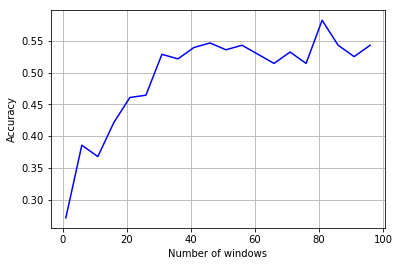

In [116]:
pylab.grid(True)
pylab.plot(x1_1000, y1_1000, 'b-')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')

In [ ]:
#Извлечем из эмг фичу rms и ar, соединим и сохраним
#Для частоты 2000
featureSet2 = [root_mean_square]
exctract_and_save(emg=X_2000, features_list=featureSet2, N=100, feature_set_num=2)

In [117]:
AR6_2000 = autoregression_coefficients(X_2000, order=6, n_channels=12)

In [127]:
for n in range(1, 101):
    X = np.load('data/ninaPro/DB2/featureSet2/X_{n:d}_2000.npy'.format(n=n))
    X = np.concatenate((X, AR6_2000), axis=1)
    np.save('data/ninaPro/DB2/featureSet2/X_{n:d}_2000.npy'.format(n=n), X)

In [128]:
X = np.load('data/ninaPro/DB2/featureSet2/X_70_2000.npy'.format(n=n))
print(X.shape)

(1680, 912)


In [ ]:
#Для частоты 1000
exctract_and_save(emg=X_1000, features_list=featureSet2, N=100, feature_set_num=2, rate=1000)

In [130]:
AR6_1000 = autoregression_coefficients(X_1000, order=6, n_channels=12)

In [131]:
for n in range(1, 101):
    X = np.load('data/ninaPro/DB2/featureSet2/X_{n:d}_1000.npy'.format(n=n))
    X = np.concatenate((X, AR6_1000), axis=1)
    np.save('data/ninaPro/DB2/featureSet2/X_{n:d}_1000.npy'.format(n=n), X)

In [132]:
x2_2000, y2_2000 = arrays_for_plot(feature_set_n=2, rate=2000, step=5)

Epoch 1/150
1400/1400 [==============================] - 14s 10ms/step - loss: 1.9635 - acc: 0.1236
Epoch 2/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.9517 - acc: 0.1450
Epoch 3/150
1400/1400 [==============================] - 0s 102us/step - loss: 1.9457 - acc: 0.1457
Epoch 4/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.9415 - acc: 0.1650
Epoch 5/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.9407 - acc: 0.1614
Epoch 6/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.9404 - acc: 0.1479
Epoch 7/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.9341 - acc: 0.1743
Epoch 8/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.9362 - acc: 0.1664
Epoch 9/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.9310 - acc: 0.1807 0s - loss: 1.9367 - acc: 0.17
Epoch 10/150
1400/1400 [==============================] - 0s 110us/step

1400/1400 [==============================] - 0s 116us/step - loss: 1.8023 - acc: 0.2836
Epoch 82/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.8011 - acc: 0.2743
Epoch 83/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.8114 - acc: 0.2607
Epoch 84/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.7946 - acc: 0.2821
Epoch 85/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8062 - acc: 0.2629
Epoch 86/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.8101 - acc: 0.2586
Epoch 87/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.8000 - acc: 0.2693
Epoch 88/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.7976 - acc: 0.2686
Epoch 89/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.8055 - acc: 0.2793
Epoch 90/150
1400/1400 [==============================] - 0s 90us/step - loss: 1.7978 - acc: 0.2750
Epoch 91

1400/1400 [==============================] - 0s 115us/step - loss: 1.9291 - acc: 0.1879
Epoch 12/150
1400/1400 [==============================] - 0s 91us/step - loss: 1.9259 - acc: 0.1821
Epoch 13/150
1400/1400 [==============================] - 0s 97us/step - loss: 1.9229 - acc: 0.1986
Epoch 14/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.9222 - acc: 0.2071
Epoch 15/150
1400/1400 [==============================] - 0s 102us/step - loss: 1.9206 - acc: 0.1943
Epoch 16/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.9215 - acc: 0.1979
Epoch 17/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.9165 - acc: 0.1943
Epoch 18/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.9169 - acc: 0.1979
Epoch 19/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.9145 - acc: 0.2029
Epoch 20/150
1400/1400 [==============================] - 0s 97us/step - loss: 1.9166 - acc: 0.2014
Epoch 21/

1400/1400 [==============================] - 0s 114us/step - loss: 1.7882 - acc: 0.2714
Epoch 93/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.7812 - acc: 0.2864
Epoch 94/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7862 - acc: 0.2757
Epoch 95/150
1400/1400 [==============================] - 0s 94us/step - loss: 1.7806 - acc: 0.2836
Epoch 96/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.7825 - acc: 0.2871
Epoch 97/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.7729 - acc: 0.2829
Epoch 98/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7816 - acc: 0.2693
Epoch 99/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.7762 - acc: 0.2850: 0s - loss: 1.7567 - acc: 0.30
Epoch 100/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7750 - acc: 0.2764
Epoch 101/150
1400/1400 [==============================] - 0s 98us/step - lo

1400/1400 [==============================] - 0s 118us/step - loss: 1.9322 - acc: 0.1986
Epoch 23/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9331 - acc: 0.1857
Epoch 24/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.9296 - acc: 0.1850
Epoch 25/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9296 - acc: 0.1943
Epoch 26/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.9285 - acc: 0.1921
Epoch 27/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.9282 - acc: 0.1779
Epoch 28/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.9276 - acc: 0.1900
Epoch 29/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.9274 - acc: 0.1907
Epoch 30/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.9254 - acc: 0.1843
Epoch 31/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.9253 - acc: 0.1979
Epo

1400/1400 [==============================] - 0s 145us/step - loss: 1.8184 - acc: 0.2686
Epoch 103/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.8114 - acc: 0.2800
Epoch 104/150
1400/1400 [==============================] - 0s 120us/step - loss: 1.8131 - acc: 0.2779
Epoch 105/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.8158 - acc: 0.2779
Epoch 106/150
1400/1400 [==============================] - 0s 119us/step - loss: 1.8159 - acc: 0.2907
Epoch 107/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.8098 - acc: 0.2693
Epoch 108/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.8115 - acc: 0.2871
Epoch 109/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.8059 - acc: 0.2757
Epoch 110/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.8089 - acc: 0.2814
Epoch 111/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8032 - acc: 0

1400/1400 [==============================] - 0s 107us/step - loss: 1.9186 - acc: 0.2143
Epoch 32/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.9165 - acc: 0.2193
Epoch 33/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.9147 - acc: 0.2164
Epoch 34/150
1400/1400 [==============================] - 0s 84us/step - loss: 1.9148 - acc: 0.2021
Epoch 35/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9117 - acc: 0.2200
Epoch 36/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.9086 - acc: 0.2286
Epoch 37/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9109 - acc: 0.2164
Epoch 38/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.9045 - acc: 0.2407
Epoch 39/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.9062 - acc: 0.2143
Epoch 40/150
1400/1400 [==============================] - 0s 93us/step - loss: 1.9015 - acc: 0.2257
Epoch 

1400/1400 [==============================] - 0s 98us/step - loss: 1.7094 - acc: 0.3343
Epoch 112/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.7123 - acc: 0.3386
Epoch 113/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7180 - acc: 0.3271
Epoch 114/150
1400/1400 [==============================] - 0s 90us/step - loss: 1.7093 - acc: 0.3429
Epoch 115/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.7074 - acc: 0.3229
Epoch 116/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.6930 - acc: 0.3493
Epoch 117/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.6929 - acc: 0.3350
Epoch 118/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.6946 - acc: 0.3157
Epoch 119/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.6839 - acc: 0.3450
Epoch 120/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.6868 - acc: 0.3

1400/1400 [==============================] - 0s 103us/step - loss: 1.8822 - acc: 0.2350
Epoch 42/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8801 - acc: 0.2486
Epoch 43/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.8781 - acc: 0.2493
Epoch 44/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8779 - acc: 0.2407
Epoch 45/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8779 - acc: 0.2300
Epoch 46/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.8730 - acc: 0.2421
Epoch 47/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.8667 - acc: 0.2407
Epoch 48/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.8668 - acc: 0.2479
Epoch 49/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.8635 - acc: 0.2629
Epoch 50/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.8623 - acc: 0.2557
Epo

1400/1400 [==============================] - 0s 99us/step - loss: 1.6294 - acc: 0.3521
Epoch 122/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.5986 - acc: 0.3679
Epoch 123/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.6110 - acc: 0.3693
Epoch 124/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.5995 - acc: 0.3557
Epoch 125/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.6069 - acc: 0.3657
Epoch 126/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.5941 - acc: 0.3743
Epoch 127/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.5960 - acc: 0.3536
Epoch 128/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5906 - acc: 0.3807
Epoch 129/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.5840 - acc: 0.3857
Epoch 130/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.5720 - acc: 0.

1400/1400 [==============================] - 0s 183us/step - loss: 1.7620 - acc: 0.3050
Epoch 52/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.7576 - acc: 0.3000
Epoch 53/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.7541 - acc: 0.2900
Epoch 54/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.7532 - acc: 0.2914
Epoch 55/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.7447 - acc: 0.3007
Epoch 56/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.7443 - acc: 0.2914
Epoch 57/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.7453 - acc: 0.3014
Epoch 58/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.7247 - acc: 0.3000
Epoch 59/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.7281 - acc: 0.2993
Epoch 60/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.7233 - acc: 0.3071
Epo

1400/1400 [==============================] - 0s 187us/step - loss: 1.4831 - acc: 0.3993
Epoch 132/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.4919 - acc: 0.3986
Epoch 133/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.4798 - acc: 0.4121
Epoch 134/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.4856 - acc: 0.4179
Epoch 135/150
1400/1400 [==============================] - 0s 195us/step - loss: 1.4950 - acc: 0.3993
Epoch 136/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.4986 - acc: 0.4050
Epoch 137/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.4951 - acc: 0.3971
Epoch 138/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4799 - acc: 0.4021
Epoch 139/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.4823 - acc: 0.4014
Epoch 140/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.4723 - acc: 0

1400/1400 [==============================] - 0s 170us/step - loss: 1.8376 - acc: 0.2964
Epoch 62/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.8433 - acc: 0.2457
Epoch 63/150
1400/1400 [==============================] - 0s 143us/step - loss: 1.8379 - acc: 0.2793
Epoch 64/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.8317 - acc: 0.2836
Epoch 65/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.8277 - acc: 0.2807
Epoch 66/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.8224 - acc: 0.2936
Epoch 67/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.8191 - acc: 0.2929
Epoch 68/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.8169 - acc: 0.2843
Epoch 69/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.8175 - acc: 0.2736
Epoch 70/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.8117 - acc: 0.2843
Epo

1400/1400 [==============================] - 0s 138us/step - loss: 1.5042 - acc: 0.4236
Epoch 142/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.5025 - acc: 0.4207
Epoch 143/150
1400/1400 [==============================] - 0s 144us/step - loss: 1.5077 - acc: 0.4100
Epoch 144/150
1400/1400 [==============================] - 0s 139us/step - loss: 1.4876 - acc: 0.4371
Epoch 145/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.4915 - acc: 0.4236
Epoch 146/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.4868 - acc: 0.4314
Epoch 147/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.4839 - acc: 0.4229
Epoch 148/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.4784 - acc: 0.4264
Epoch 149/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4707 - acc: 0.4414
Epoch 150/150
280/280 [==============================] - 2s 6ms/step
Epoch 1/150
1400/1400 [====

1400/1400 [==============================] - 0s 153us/step - loss: 1.7912 - acc: 0.2736
Epoch 72/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.7893 - acc: 0.2736
Epoch 73/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.7774 - acc: 0.2986
Epoch 74/150
1400/1400 [==============================] - 0s 139us/step - loss: 1.7785 - acc: 0.2943
Epoch 75/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.7806 - acc: 0.2829
Epoch 76/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.7752 - acc: 0.2850
Epoch 77/150
1400/1400 [==============================] - 0s 143us/step - loss: 1.7789 - acc: 0.2800
Epoch 78/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.7662 - acc: 0.2871
Epoch 79/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.7687 - acc: 0.2943
Epoch 80/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.7681 - acc: 0.2907
Epo

Epoch 1/150
1400/1400 [==============================] - 4s 3ms/step - loss: 1.9455 - acc: 0.1464
Epoch 2/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.9400 - acc: 0.1571
Epoch 3/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9414 - acc: 0.1693
Epoch 4/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9372 - acc: 0.1671
Epoch 5/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.9348 - acc: 0.1771
Epoch 6/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.9293 - acc: 0.1836
Epoch 7/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.9289 - acc: 0.1857
Epoch 8/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.9246 - acc: 0.2007
Epoch 9/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.9243 - acc: 0.1929
Epoch 10/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.9234 - acc: 0.2050
E

1400/1400 [==============================] - 0s 154us/step - loss: 1.5531 - acc: 0.3779
Epoch 83/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.5436 - acc: 0.4129
Epoch 84/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.5437 - acc: 0.4057
Epoch 85/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.5407 - acc: 0.3879
Epoch 86/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.5383 - acc: 0.4064
Epoch 87/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.5391 - acc: 0.4129
Epoch 88/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.5364 - acc: 0.4043
Epoch 89/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5381 - acc: 0.3936
Epoch 90/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.5335 - acc: 0.4100
Epoch 91/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.5255 - acc: 0.4143
Epo

1400/1400 [==============================] - 0s 155us/step - loss: 1.8990 - acc: 0.2486
Epoch 13/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.8965 - acc: 0.2264
Epoch 14/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.8928 - acc: 0.2357
Epoch 15/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.8870 - acc: 0.2286
Epoch 16/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.8849 - acc: 0.2350
Epoch 17/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.8760 - acc: 0.2371
Epoch 18/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.8749 - acc: 0.2364
Epoch 19/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.8745 - acc: 0.2179
Epoch 20/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.8642 - acc: 0.2414
Epoch 21/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.8580 - acc: 0.2421
Epo

1400/1400 [==============================] - 0s 154us/step - loss: 1.5172 - acc: 0.3993
Epoch 94/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.5125 - acc: 0.4100
Epoch 95/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.5168 - acc: 0.4121
Epoch 96/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.5214 - acc: 0.4207
Epoch 97/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.4986 - acc: 0.4093
Epoch 98/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.5057 - acc: 0.4143
Epoch 99/150
1400/1400 [==============================] - 0s 143us/step - loss: 1.4946 - acc: 0.4307
Epoch 100/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.5023 - acc: 0.4136
Epoch 101/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.5029 - acc: 0.4100
Epoch 102/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.4846 - acc: 0.4207


1400/1400 [==============================] - 0s 165us/step - loss: 1.9063 - acc: 0.1986
Epoch 24/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.9022 - acc: 0.2121
Epoch 25/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9023 - acc: 0.2200
Epoch 26/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.8990 - acc: 0.2393
Epoch 27/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.8959 - acc: 0.2329
Epoch 28/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.8916 - acc: 0.2386
Epoch 29/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.8896 - acc: 0.2486
Epoch 30/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.8858 - acc: 0.2600
Epoch 31/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.8839 - acc: 0.2436
Epoch 32/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.8809 - acc: 0.2664
Epo

1400/1400 [==============================] - 0s 227us/step - loss: 1.4868 - acc: 0.4214
Epoch 105/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.4958 - acc: 0.4200
Epoch 106/150
1400/1400 [==============================] - 0s 209us/step - loss: 1.4867 - acc: 0.4236
Epoch 107/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.4976 - acc: 0.4179
Epoch 108/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.4978 - acc: 0.4136
Epoch 109/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.4733 - acc: 0.4429
Epoch 110/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.4827 - acc: 0.4364
Epoch 111/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.4804 - acc: 0.4264
Epoch 112/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.4750 - acc: 0.4150
Epoch 113/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.4722 - acc: 0

1400/1400 [==============================] - 0s 195us/step - loss: 1.8729 - acc: 0.2621
Epoch 35/150
1400/1400 [==============================] - 0s 243us/step - loss: 1.8669 - acc: 0.2721
Epoch 36/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.8654 - acc: 0.2593
Epoch 37/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.8640 - acc: 0.2721
Epoch 38/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.8591 - acc: 0.2671
Epoch 39/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.8576 - acc: 0.2743
Epoch 40/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.8502 - acc: 0.2793
Epoch 41/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.8406 - acc: 0.2764
Epoch 42/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.8417 - acc: 0.2764
Epoch 43/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.8362 - acc: 0.2964
Epo

1400/1400 [==============================] - 0s 180us/step - loss: 1.4823 - acc: 0.4307
Epoch 115/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.4797 - acc: 0.4236
Epoch 116/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.4664 - acc: 0.4307
Epoch 117/150
1400/1400 [==============================] - 0s 227us/step - loss: 1.4758 - acc: 0.4250
Epoch 118/150
1400/1400 [==============================] - 0s 294us/step - loss: 1.4689 - acc: 0.4300
Epoch 119/150
1400/1400 [==============================] - 0s 250us/step - loss: 1.4751 - acc: 0.4371
Epoch 120/150
1400/1400 [==============================] - 0s 239us/step - loss: 1.4556 - acc: 0.4329
Epoch 121/150
1400/1400 [==============================] - 0s 308us/step - loss: 1.4452 - acc: 0.4500
Epoch 122/150
1400/1400 [==============================] - 0s 328us/step - loss: 1.4499 - acc: 0.4400
Epoch 123/150
1400/1400 [==============================] - 0s 326us/step - loss: 1.4491 - acc: 0

1400/1400 [==============================] - 0s 212us/step - loss: 1.7553 - acc: 0.3164
Epoch 45/150
1400/1400 [==============================] - 0s 233us/step - loss: 1.7473 - acc: 0.3307
Epoch 46/150
1400/1400 [==============================] - 0s 246us/step - loss: 1.7421 - acc: 0.3271
Epoch 47/150
1400/1400 [==============================] - 0s 227us/step - loss: 1.7309 - acc: 0.3379
Epoch 48/150
1400/1400 [==============================] - 0s 244us/step - loss: 1.7291 - acc: 0.3357
Epoch 49/150
1400/1400 [==============================] - 0s 220us/step - loss: 1.7129 - acc: 0.3393
Epoch 50/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.7066 - acc: 0.3500
Epoch 51/150
1400/1400 [==============================] - 0s 276us/step - loss: 1.6976 - acc: 0.3479
Epoch 52/150
1400/1400 [==============================] - 0s 300us/step - loss: 1.6929 - acc: 0.3521
Epoch 53/150
1400/1400 [==============================] - 0s 256us/step - loss: 1.6878 - acc: 0.3529
Epo

1400/1400 [==============================] - 0s 182us/step - loss: 1.3791 - acc: 0.4729
Epoch 125/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.3800 - acc: 0.4650
Epoch 126/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.3879 - acc: 0.4529
Epoch 127/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.3746 - acc: 0.4807
Epoch 128/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.3750 - acc: 0.4721
Epoch 129/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.3553 - acc: 0.4871
Epoch 130/150
1400/1400 [==============================] - 0s 229us/step - loss: 1.3630 - acc: 0.4750
Epoch 131/150
1400/1400 [==============================] - 0s 227us/step - loss: 1.3761 - acc: 0.4786
Epoch 132/150
1400/1400 [==============================] - 0s 205us/step - loss: 1.3721 - acc: 0.4771
Epoch 133/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.3634 - acc: 0

1400/1400 [==============================] - 0s 199us/step - loss: 1.6397 - acc: 0.3579
Epoch 55/150
1400/1400 [==============================] - 0s 203us/step - loss: 1.6264 - acc: 0.3521
Epoch 56/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.6459 - acc: 0.3329
Epoch 57/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.6190 - acc: 0.3579
Epoch 58/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.6138 - acc: 0.3514
Epoch 59/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.6048 - acc: 0.3779
Epoch 60/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.6089 - acc: 0.3457
Epoch 61/150
1400/1400 [==============================] - 0s 205us/step - loss: 1.6008 - acc: 0.3621
Epoch 62/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.5895 - acc: 0.3743
Epoch 63/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.5908 - acc: 0.3579
Epo

1400/1400 [==============================] - 0s 199us/step - loss: 1.3577 - acc: 0.4650
Epoch 135/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.3514 - acc: 0.4607
Epoch 136/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.3524 - acc: 0.4643
Epoch 137/150
1400/1400 [==============================] - 0s 201us/step - loss: 1.3450 - acc: 0.4914
Epoch 138/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.3493 - acc: 0.4686
Epoch 139/150
1400/1400 [==============================] - 0s 217us/step - loss: 1.3375 - acc: 0.4921
Epoch 140/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.3372 - acc: 0.4779
Epoch 141/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.3366 - acc: 0.4750
Epoch 142/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.3324 - acc: 0.4779
Epoch 143/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.3319 - acc: 0

1400/1400 [==============================] - 0s 187us/step - loss: 1.6519 - acc: 0.3450
Epoch 65/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.6155 - acc: 0.3664
Epoch 66/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.6227 - acc: 0.3764
Epoch 67/150
1400/1400 [==============================] - 0s 208us/step - loss: 1.5964 - acc: 0.3743
Epoch 68/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.6058 - acc: 0.3700
Epoch 69/150
1400/1400 [==============================] - 0s 205us/step - loss: 1.6132 - acc: 0.3700
Epoch 70/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.5890 - acc: 0.3807
Epoch 71/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.6025 - acc: 0.3643
Epoch 72/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.5782 - acc: 0.3843
Epoch 73/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.5884 - acc: 0.3743
Epo

1400/1400 [==============================] - 0s 188us/step - loss: 1.2799 - acc: 0.4993
Epoch 145/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.2678 - acc: 0.5271
Epoch 146/150
1400/1400 [==============================] - 0s 248us/step - loss: 1.2672 - acc: 0.5264
Epoch 147/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.2600 - acc: 0.5300
Epoch 148/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.2652 - acc: 0.5343
Epoch 149/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.2628 - acc: 0.5279
Epoch 150/150
280/280 [==============================] - 2s 7ms/step
Epoch 1/150
1400/1400 [==============================] - 4s 3ms/step - loss: 1.9465 - acc: 0.1400
Epoch 2/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.9479 - acc: 0.1336
Epoch 3/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.9458 - acc: 0.1350
Epoch 4/150
1400/1400 [============

1400/1400 [==============================] - 0s 167us/step - loss: 1.6183 - acc: 0.3771
Epoch 75/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.6061 - acc: 0.3743
Epoch 76/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.5952 - acc: 0.4007
Epoch 77/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.5879 - acc: 0.4079
Epoch 78/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.5874 - acc: 0.4064
Epoch 79/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.5932 - acc: 0.3907
Epoch 80/150
1400/1400 [==============================] - 0s 195us/step - loss: 1.5691 - acc: 0.3986
Epoch 81/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.5761 - acc: 0.4014
Epoch 82/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5698 - acc: 0.3857
Epoch 83/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.5605 - acc: 0.3907
Epo

1400/1400 [==============================] - 0s 253us/step - loss: 1.9428 - acc: 0.1400
Epoch 5/150
1400/1400 [==============================] - 0s 256us/step - loss: 1.9402 - acc: 0.1557
Epoch 6/150
1400/1400 [==============================] - 0s 273us/step - loss: 1.9400 - acc: 0.1693
Epoch 7/150
1400/1400 [==============================] - 1s 358us/step - loss: 1.9377 - acc: 0.1771
Epoch 8/150
1400/1400 [==============================] - 0s 233us/step - loss: 1.9362 - acc: 0.1850
Epoch 9/150
1400/1400 [==============================] - 0s 210us/step - loss: 1.9335 - acc: 0.1900
Epoch 10/150
1400/1400 [==============================] - 0s 222us/step - loss: 1.9330 - acc: 0.1886
Epoch 11/150
1400/1400 [==============================] - 0s 217us/step - loss: 1.9304 - acc: 0.1921
Epoch 12/150
1400/1400 [==============================] - 0s 224us/step - loss: 1.9282 - acc: 0.1964
Epoch 13/150
1400/1400 [==============================] - 0s 222us/step - loss: 1.9273 - acc: 0.2007
Epoch 14

1400/1400 [==============================] - 0s 265us/step - loss: 1.6010 - acc: 0.3664
Epoch 86/150
1400/1400 [==============================] - 0s 279us/step - loss: 1.5908 - acc: 0.3857
Epoch 87/150
1400/1400 [==============================] - 0s 313us/step - loss: 1.5843 - acc: 0.3886
Epoch 88/150
1400/1400 [==============================] - 0s 297us/step - loss: 1.5827 - acc: 0.3836
Epoch 89/150
1400/1400 [==============================] - 0s 290us/step - loss: 1.5849 - acc: 0.3914
Epoch 90/150
1400/1400 [==============================] - 0s 245us/step - loss: 1.5616 - acc: 0.3943
Epoch 91/150
1400/1400 [==============================] - 0s 266us/step - loss: 1.5681 - acc: 0.3664
Epoch 92/150
1400/1400 [==============================] - 0s 270us/step - loss: 1.5555 - acc: 0.3814
Epoch 93/150
1400/1400 [==============================] - 0s 300us/step - loss: 1.5656 - acc: 0.3850
Epoch 94/150
1400/1400 [==============================] - 0s 307us/step - loss: 1.5603 - acc: 0.3914
Epo

1400/1400 [==============================] - 0s 192us/step - loss: 1.9046 - acc: 0.1871
Epoch 16/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.8980 - acc: 0.2014
Epoch 17/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.8963 - acc: 0.1907
Epoch 18/150
1400/1400 [==============================] - 0s 202us/step - loss: 1.8917 - acc: 0.1864
Epoch 19/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.8846 - acc: 0.1986
Epoch 20/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.8825 - acc: 0.2007
Epoch 21/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.8776 - acc: 0.2121
Epoch 22/150
1400/1400 [==============================] - 0s 195us/step - loss: 1.8787 - acc: 0.2043
Epoch 23/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.8713 - acc: 0.2150
Epoch 24/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.8688 - acc: 0.2236
Epo

1400/1400 [==============================] - 0s 194us/step - loss: 1.4753 - acc: 0.4443
Epoch 97/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.4535 - acc: 0.4400
Epoch 98/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.4731 - acc: 0.4386
Epoch 99/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.4583 - acc: 0.4536
Epoch 100/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.4567 - acc: 0.4500
Epoch 101/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.4503 - acc: 0.4429
Epoch 102/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.4566 - acc: 0.4386
Epoch 103/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.4429 - acc: 0.4586
Epoch 104/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.4279 - acc: 0.4457
Epoch 105/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.4276 - acc: 0.46

1400/1400 [==============================] - 0s 183us/step - loss: 1.8811 - acc: 0.2486
Epoch 27/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.8819 - acc: 0.2421
Epoch 28/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.8798 - acc: 0.2507
Epoch 29/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.8736 - acc: 0.2571
Epoch 30/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.8666 - acc: 0.2693
Epoch 31/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.8573 - acc: 0.2743
Epoch 32/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.8547 - acc: 0.2736
Epoch 33/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.8518 - acc: 0.2700
Epoch 34/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.8404 - acc: 0.2807
Epoch 35/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.8406 - acc: 0.2836
Epo

1400/1400 [==============================] - 0s 190us/step - loss: 1.4644 - acc: 0.4264
Epoch 108/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.4429 - acc: 0.4350
Epoch 109/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.4461 - acc: 0.4343
Epoch 110/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.4360 - acc: 0.4464
Epoch 111/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.4333 - acc: 0.4307
Epoch 112/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.4588 - acc: 0.4336
Epoch 113/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.4424 - acc: 0.4450
Epoch 114/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.4322 - acc: 0.4286
Epoch 115/150
1400/1400 [==============================] - 0s 297us/step - loss: 1.4111 - acc: 0.4600
Epoch 116/150
1400/1400 [==============================] - 0s 220us/step - loss: 1.4215 - acc: 0

1400/1400 [==============================] - 0s 183us/step - loss: 1.7296 - acc: 0.3300
Epoch 38/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.7286 - acc: 0.3279 0s - loss: 1.7220 - acc: 0.33
Epoch 39/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.7210 - acc: 0.3364
Epoch 40/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.7169 - acc: 0.3507
Epoch 41/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.7060 - acc: 0.3407
Epoch 42/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.7033 - acc: 0.3471
Epoch 43/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.6825 - acc: 0.3586
Epoch 44/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.6837 - acc: 0.3536
Epoch 45/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.6588 - acc: 0.3679
Epoch 46/150
1400/1400 [==============================] - 0s 180us/step - 

1400/1400 [==============================] - 0s 188us/step - loss: 1.2637 - acc: 0.5257
Epoch 118/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.2685 - acc: 0.5221
Epoch 119/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.2512 - acc: 0.5264
Epoch 120/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.2585 - acc: 0.5307
Epoch 121/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.2300 - acc: 0.5393
Epoch 122/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.2425 - acc: 0.5314
Epoch 123/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.2367 - acc: 0.5336
Epoch 124/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.2522 - acc: 0.5250
Epoch 125/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.2257 - acc: 0.5571
Epoch 126/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.2413 - acc: 0

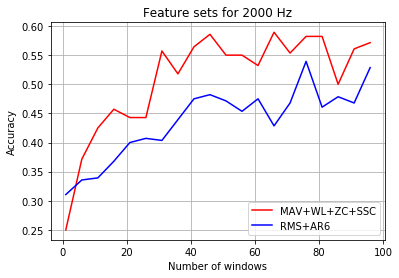

In [137]:
pylab.grid(True)
pylab.plot(x1_2000, y1_2000, 'r-', label='MAV+WL+ZC+SSC')
pylab.plot(x2_2000, y2_2000, 'b-', label='RMS+AR6')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')
pylab.legend(loc='lower right')
pylab.title('Feature sets for 2000 Hz')

In [139]:
x2_1000, y2_1000 = arrays_for_plot(feature_set_n=2, rate=1000, step=5)

Epoch 1/150
1400/1400 [==============================] - 6s 4ms/step - loss: 2.0137 - acc: 0.1329
Epoch 2/150
1400/1400 [==============================] - 0s 79us/step - loss: 1.9601 - acc: 0.1350
Epoch 3/150
1400/1400 [==============================] - 0s 80us/step - loss: 1.9469 - acc: 0.1421
Epoch 4/150
1400/1400 [==============================] - 0s 87us/step - loss: 1.9489 - acc: 0.1371
Epoch 5/150
1400/1400 [==============================] - 0s 85us/step - loss: 1.9410 - acc: 0.1536
Epoch 6/150
1400/1400 [==============================] - 0s 75us/step - loss: 1.9424 - acc: 0.1571
Epoch 7/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.9391 - acc: 0.1650
Epoch 8/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.9356 - acc: 0.1679
Epoch 9/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.9353 - acc: 0.1800
Epoch 10/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.9346 - acc: 0.1679
Epoch 11/1

1400/1400 [==============================] - 0s 73us/step - loss: 1.8571 - acc: 0.2357
Epoch 83/150
1400/1400 [==============================] - 0s 73us/step - loss: 1.8621 - acc: 0.2271
Epoch 84/150
1400/1400 [==============================] - 0s 75us/step - loss: 1.8562 - acc: 0.2343
Epoch 85/150
1400/1400 [==============================] - 0s 83us/step - loss: 1.8562 - acc: 0.2386
Epoch 86/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.8514 - acc: 0.2450
Epoch 87/150
1400/1400 [==============================] - 0s 70us/step - loss: 1.8573 - acc: 0.2264
Epoch 88/150
1400/1400 [==============================] - 0s 68us/step - loss: 1.8633 - acc: 0.2193
Epoch 89/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.8576 - acc: 0.2321
Epoch 90/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.8568 - acc: 0.2257
Epoch 91/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.8529 - acc: 0.2464
Epoch 92/150


1400/1400 [==============================] - 0s 148us/step - loss: 1.9420 - acc: 0.1621
Epoch 13/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.9368 - acc: 0.1907
Epoch 14/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.9394 - acc: 0.1821
Epoch 15/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.9391 - acc: 0.1721
Epoch 16/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.9357 - acc: 0.1807
Epoch 17/150
1400/1400 [==============================] - 0s 143us/step - loss: 1.9360 - acc: 0.1886
Epoch 18/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.9324 - acc: 0.1900
Epoch 19/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.9351 - acc: 0.1843
Epoch 20/150
1400/1400 [==============================] - 0s 122us/step - loss: 1.9369 - acc: 0.1686
Epoch 21/150
1400/1400 [==============================] - 0s 122us/step - loss: 1.9284 - acc: 0.1929
Epoch

1400/1400 [==============================] - 0s 100us/step - loss: 1.8347 - acc: 0.2679
Epoch 94/150
1400/1400 [==============================] - 0s 84us/step - loss: 1.8279 - acc: 0.2671
Epoch 95/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8331 - acc: 0.2814
Epoch 96/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.8297 - acc: 0.2700
Epoch 97/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.8291 - acc: 0.2757
Epoch 98/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.8243 - acc: 0.2686
Epoch 99/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.8243 - acc: 0.2871
Epoch 100/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.8198 - acc: 0.2921
Epoch 101/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.8205 - acc: 0.2850
Epoch 102/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.8192 - acc: 0.2871
E

1400/1400 [==============================] - 0s 107us/step - loss: 1.9216 - acc: 0.2050
Epoch 24/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.9207 - acc: 0.2136
Epoch 25/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9212 - acc: 0.2050
Epoch 26/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.9167 - acc: 0.2314
Epoch 27/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.9186 - acc: 0.2186
Epoch 28/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.9171 - acc: 0.2136
Epoch 29/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9166 - acc: 0.2200
Epoch 30/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.9173 - acc: 0.2193
Epoch 31/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.9126 - acc: 0.2229
Epoch 32/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.9116 - acc: 0.2257
Epoch 33

1400/1400 [==============================] - 0s 111us/step - loss: 1.7438 - acc: 0.3021
Epoch 105/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.7458 - acc: 0.3107
Epoch 106/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.7278 - acc: 0.3250
Epoch 107/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.7290 - acc: 0.3179
Epoch 108/150
1400/1400 [==============================] - 0s 102us/step - loss: 1.7307 - acc: 0.3150
Epoch 109/150
1400/1400 [==============================] - 0s 99us/step - loss: 1.7272 - acc: 0.3314
Epoch 110/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.7250 - acc: 0.3336
Epoch 111/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.7159 - acc: 0.3364
Epoch 112/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.7139 - acc: 0.3343
Epoch 113/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.7143 - acc: 0.3021

1400/1400 [==============================] - 0s 113us/step - loss: 1.9000 - acc: 0.2171
Epoch 35/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.8971 - acc: 0.2186
Epoch 36/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8919 - acc: 0.2243
Epoch 37/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.8900 - acc: 0.2407
Epoch 38/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.8884 - acc: 0.2229
Epoch 39/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.8889 - acc: 0.2236
Epoch 40/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.8845 - acc: 0.2407
Epoch 41/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.8760 - acc: 0.2464 0s - loss: 1.8729 - acc: 0.255
Epoch 42/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.8779 - acc: 0.2307
Epoch 43/150
1400/1400 [==============================] - 0s 123us/step -

1400/1400 [==============================] - 0s 113us/step - loss: 1.6432 - acc: 0.3514
Epoch 115/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.6387 - acc: 0.3429
Epoch 116/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.6274 - acc: 0.3736
Epoch 117/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.6277 - acc: 0.3457
Epoch 118/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.6394 - acc: 0.3486
Epoch 119/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.6240 - acc: 0.3679
Epoch 120/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.6252 - acc: 0.3479
Epoch 121/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.6082 - acc: 0.3579
Epoch 122/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.6035 - acc: 0.3650
Epoch 123/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.5989 - acc: 0.

1400/1400 [==============================] - 0s 108us/step - loss: 1.9054 - acc: 0.2329
Epoch 45/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.9051 - acc: 0.2264
Epoch 46/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.8974 - acc: 0.2379
Epoch 47/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.8988 - acc: 0.2329
Epoch 48/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.8959 - acc: 0.2286
Epoch 49/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.8945 - acc: 0.2314
Epoch 50/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8920 - acc: 0.2343
Epoch 51/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8958 - acc: 0.2279
Epoch 52/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.8844 - acc: 0.2493
Epoch 53/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.8829 - acc: 0.2507
Epo

Epoch 125/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.6212 - acc: 0.3686
Epoch 126/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.6207 - acc: 0.3636
Epoch 127/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.6105 - acc: 0.3679
Epoch 128/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.6014 - acc: 0.3750
Epoch 129/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.6018 - acc: 0.3664
Epoch 130/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.5831 - acc: 0.3800
Epoch 131/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.5916 - acc: 0.3850
Epoch 132/150
1400/1400 [==============================] - 0s 115us/step - loss: 1.5821 - acc: 0.3764
Epoch 133/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.5789 - acc: 0.3679
Epoch 134/150
1400/1400 [==============================] - 0s 110us/step - loss: 1

1400/1400 [==============================] - 0s 129us/step - loss: 1.8380 - acc: 0.2436
Epoch 56/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.8301 - acc: 0.2564
Epoch 57/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.8285 - acc: 0.2450
Epoch 58/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.8223 - acc: 0.2721
Epoch 59/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.8165 - acc: 0.2714
Epoch 60/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.8160 - acc: 0.2700
Epoch 61/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.8216 - acc: 0.2479
Epoch 62/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.8147 - acc: 0.2671
Epoch 63/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.8076 - acc: 0.2586
Epoch 64/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.8102 - acc: 0.2700
Epo

1400/1400 [==============================] - 0s 130us/step - loss: 1.5110 - acc: 0.4250
Epoch 136/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.5119 - acc: 0.4186
Epoch 137/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.5058 - acc: 0.3971
Epoch 138/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.5218 - acc: 0.4086
Epoch 139/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.5117 - acc: 0.4214
Epoch 140/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.5007 - acc: 0.4071
Epoch 141/150
1400/1400 [==============================] - 0s 122us/step - loss: 1.5005 - acc: 0.4143
Epoch 142/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.4871 - acc: 0.4229
Epoch 143/150
1400/1400 [==============================] - 0s 123us/step - loss: 1.4946 - acc: 0.4121
Epoch 144/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.4868 - acc: 0

1400/1400 [==============================] - 0s 138us/step - loss: 1.7838 - acc: 0.2914
Epoch 66/150
1400/1400 [==============================] - 0s 139us/step - loss: 1.7683 - acc: 0.3021
Epoch 67/150
1400/1400 [==============================] - 0s 141us/step - loss: 1.7832 - acc: 0.2907
Epoch 68/150
1400/1400 [==============================] - 0s 139us/step - loss: 1.7751 - acc: 0.2936
Epoch 69/150
1400/1400 [==============================] - 0s 136us/step - loss: 1.7676 - acc: 0.2957
Epoch 70/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.7676 - acc: 0.2879
Epoch 71/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7625 - acc: 0.3064
Epoch 72/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7548 - acc: 0.3064
Epoch 73/150
1400/1400 [==============================] - 0s 204us/step - loss: 1.7557 - acc: 0.3057
Epoch 74/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.7489 - acc: 0.3207
Epo

1400/1400 [==============================] - 0s 141us/step - loss: 1.4524 - acc: 0.4329
Epoch 146/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.4674 - acc: 0.4386
Epoch 147/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.4520 - acc: 0.4529
Epoch 148/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.4390 - acc: 0.4600
Epoch 149/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.4554 - acc: 0.4479
Epoch 150/150
280/280 [==============================] - 2s 6ms/step
Epoch 1/150
1400/1400 [==============================] - 4s 3ms/step - loss: 1.9687 - acc: 0.1421
Epoch 2/150
1400/1400 [==============================] - 0s 141us/step - loss: 1.9505 - acc: 0.1407
Epoch 3/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.9468 - acc: 0.1436
Epoch 4/150
1400/1400 [==============================] - 0s 136us/step - loss: 1.9433 - acc: 0.1407
Epoch 5/150
1400/1400 [==============

1400/1400 [==============================] - 0s 145us/step - loss: 1.7519 - acc: 0.3171
Epoch 76/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.7571 - acc: 0.3264
Epoch 77/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.7596 - acc: 0.3300
Epoch 78/150
1400/1400 [==============================] - 0s 143us/step - loss: 1.7405 - acc: 0.3436
Epoch 79/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7411 - acc: 0.3314
Epoch 80/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7329 - acc: 0.3343
Epoch 81/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7321 - acc: 0.3321
Epoch 82/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.7239 - acc: 0.3407
Epoch 83/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.7228 - acc: 0.3407
Epoch 84/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.7175 - acc: 0.3371
Epo

1400/1400 [==============================] - 0s 152us/step - loss: 1.9389 - acc: 0.1664
Epoch 6/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9383 - acc: 0.1871
Epoch 7/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.9388 - acc: 0.1793
Epoch 8/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.9361 - acc: 0.1950
Epoch 9/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9365 - acc: 0.2050
Epoch 10/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9335 - acc: 0.1914
Epoch 11/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.9315 - acc: 0.1979
Epoch 12/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.9314 - acc: 0.1929
Epoch 13/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.9282 - acc: 0.2179
Epoch 14/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9267 - acc: 0.2286
Epoch 1

1400/1400 [==============================] - 0s 156us/step - loss: 1.5719 - acc: 0.4064
Epoch 87/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5671 - acc: 0.4114
Epoch 88/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.5653 - acc: 0.4086
Epoch 89/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.5448 - acc: 0.4186
Epoch 90/150
1400/1400 [==============================] - 0s 148us/step - loss: 1.5450 - acc: 0.4036
Epoch 91/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5476 - acc: 0.4136
Epoch 92/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5560 - acc: 0.3979
Epoch 93/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.5251 - acc: 0.4207
Epoch 94/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.5354 - acc: 0.4179
Epoch 95/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.5170 - acc: 0.4214
Epo

Epoch 16/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.9239 - acc: 0.2021
Epoch 17/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9200 - acc: 0.2200
Epoch 18/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.9195 - acc: 0.2157
Epoch 19/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9145 - acc: 0.2214
Epoch 20/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.9165 - acc: 0.2093
Epoch 21/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.9104 - acc: 0.2293
Epoch 22/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9080 - acc: 0.2279
Epoch 23/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.9083 - acc: 0.2164
Epoch 24/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.9014 - acc: 0.2400
Epoch 25/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.9023 - ac

1400/1400 [==============================] - 0s 155us/step - loss: 1.6887 - acc: 0.3850
Epoch 98/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.6806 - acc: 0.3864
Epoch 99/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.6743 - acc: 0.3921
Epoch 100/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.6697 - acc: 0.3943
Epoch 101/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.6641 - acc: 0.3893
Epoch 102/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.6592 - acc: 0.3857
Epoch 103/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.6391 - acc: 0.4079
Epoch 104/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.6469 - acc: 0.3907
Epoch 105/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.6424 - acc: 0.3964
Epoch 106/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.6462 - acc: 0.3

1400/1400 [==============================] - 0s 152us/step - loss: 1.8616 - acc: 0.2621
Epoch 27/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.8546 - acc: 0.2671
Epoch 28/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.8538 - acc: 0.2593
Epoch 29/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.8502 - acc: 0.2514
Epoch 30/150
1400/1400 [==============================] - 0s 149us/step - loss: 1.8399 - acc: 0.2579
Epoch 31/150
1400/1400 [==============================] - 0s 141us/step - loss: 1.8361 - acc: 0.2629
Epoch 32/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.8287 - acc: 0.2643
Epoch 33/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.8250 - acc: 0.2700
Epoch 34/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.8166 - acc: 0.2650
Epoch 35/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.8119 - acc: 0.2821
Epo

1400/1400 [==============================] - 0s 150us/step - loss: 1.4490 - acc: 0.4186
Epoch 107/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.4251 - acc: 0.4429
Epoch 108/150
1400/1400 [==============================] - 0s 140us/step - loss: 1.4317 - acc: 0.4200
Epoch 109/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.4315 - acc: 0.4271
Epoch 110/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.4437 - acc: 0.4314
Epoch 111/150
1400/1400 [==============================] - 0s 145us/step - loss: 1.4364 - acc: 0.4207
Epoch 112/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.4426 - acc: 0.4221
Epoch 113/150
1400/1400 [==============================] - 0s 142us/step - loss: 1.4442 - acc: 0.4186
Epoch 114/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.4056 - acc: 0.4543
Epoch 115/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.4100 - acc: 0

1400/1400 [==============================] - 0s 171us/step - loss: 1.8255 - acc: 0.2764
Epoch 36/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.8285 - acc: 0.2800
Epoch 37/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.8196 - acc: 0.2829
Epoch 38/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.8086 - acc: 0.2857
Epoch 39/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.8129 - acc: 0.2914
Epoch 40/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.8124 - acc: 0.2807
Epoch 41/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.8056 - acc: 0.2821
Epoch 42/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.8012 - acc: 0.2857
Epoch 43/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.7946 - acc: 0.2807
Epoch 44/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.7924 - acc: 0.3007
Epo

1400/1400 [==============================] - 0s 164us/step - loss: 1.3362 - acc: 0.5057
Epoch 117/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.3284 - acc: 0.4879
Epoch 118/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.3293 - acc: 0.4836
Epoch 119/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.3165 - acc: 0.5050
Epoch 120/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.3188 - acc: 0.4979
Epoch 121/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.3193 - acc: 0.4993
Epoch 122/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.3129 - acc: 0.4943
Epoch 123/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.3042 - acc: 0.5214
Epoch 124/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.3065 - acc: 0.5064
Epoch 125/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.2781 - acc: 0

1400/1400 [==============================] - 0s 163us/step - loss: 1.8076 - acc: 0.2793
Epoch 47/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.8084 - acc: 0.2707
Epoch 48/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.7974 - acc: 0.2793
Epoch 49/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.7978 - acc: 0.2807
Epoch 50/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.7775 - acc: 0.2993
Epoch 51/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.7823 - acc: 0.2907
Epoch 52/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.7740 - acc: 0.3036
Epoch 53/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.7738 - acc: 0.2943
Epoch 54/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.7625 - acc: 0.3050
Epoch 55/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.7618 - acc: 0.2979
Epo

Epoch 127/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.4071 - acc: 0.4450
Epoch 128/150
1400/1400 [==============================] - 0s 218us/step - loss: 1.4066 - acc: 0.4457
Epoch 129/150
1400/1400 [==============================] - 0s 224us/step - loss: 1.3846 - acc: 0.4886
Epoch 130/150
1400/1400 [==============================] - 0s 214us/step - loss: 1.3903 - acc: 0.4700
Epoch 131/150
1400/1400 [==============================] - 0s 209us/step - loss: 1.3725 - acc: 0.4779
Epoch 132/150
1400/1400 [==============================] - 0s 223us/step - loss: 1.3798 - acc: 0.4664
Epoch 133/150
1400/1400 [==============================] - 0s 221us/step - loss: 1.3857 - acc: 0.4700
Epoch 134/150
1400/1400 [==============================] - 0s 209us/step - loss: 1.3730 - acc: 0.4721
Epoch 135/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.3644 - acc: 0.4786
Epoch 136/150
1400/1400 [==============================] - 0s 233us/step - loss: 1

1400/1400 [==============================] - 0s 250us/step - loss: 1.6955 - acc: 0.3386
Epoch 58/150
1400/1400 [==============================] - 0s 234us/step - loss: 1.6920 - acc: 0.3357
Epoch 59/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.6879 - acc: 0.3329
Epoch 60/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.6879 - acc: 0.3243
Epoch 61/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.6777 - acc: 0.3393
Epoch 62/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.6723 - acc: 0.3514
Epoch 63/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.6704 - acc: 0.3457
Epoch 64/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.6641 - acc: 0.3507
Epoch 65/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.6516 - acc: 0.3507
Epoch 66/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.6605 - acc: 0.3314
Epo

1400/1400 [==============================] - 0s 186us/step - loss: 1.3728 - acc: 0.4793
Epoch 138/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.3692 - acc: 0.4857
Epoch 139/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.3576 - acc: 0.4814
Epoch 140/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.3666 - acc: 0.4800
Epoch 141/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.3665 - acc: 0.4750
Epoch 142/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.3583 - acc: 0.4879
Epoch 143/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.3504 - acc: 0.4793
Epoch 144/150
1400/1400 [==============================] - 0s 152us/step - loss: 1.3577 - acc: 0.4750
Epoch 145/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.3504 - acc: 0.4829
Epoch 146/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.3240 - acc: 0

1400/1400 [==============================] - 0s 161us/step - loss: 1.5680 - acc: 0.4100
Epoch 68/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.5572 - acc: 0.4186
Epoch 69/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.5425 - acc: 0.4150
Epoch 70/150
1400/1400 [==============================] - 0s 156us/step - loss: 1.5490 - acc: 0.4136
Epoch 71/150
1400/1400 [==============================] - 0s 158us/step - loss: 1.5423 - acc: 0.4221
Epoch 72/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.5402 - acc: 0.4086
Epoch 73/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.5362 - acc: 0.4207
Epoch 74/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.5186 - acc: 0.4329
Epoch 75/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.5186 - acc: 0.4307
Epoch 76/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.5084 - acc: 0.4350
Epo

1400/1400 [==============================] - 0s 162us/step - loss: 1.1796 - acc: 0.5471
Epoch 148/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.1987 - acc: 0.5486
Epoch 149/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.2026 - acc: 0.5586
Epoch 150/150
280/280 [==============================] - 2s 7ms/step
Epoch 1/150
1400/1400 [==============================] - 5s 3ms/step - loss: 1.9539 - acc: 0.1693
Epoch 2/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.9456 - acc: 0.1729
Epoch 3/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.9428 - acc: 0.1750
Epoch 4/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.9375 - acc: 0.2000
Epoch 5/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.9360 - acc: 0.2100
Epoch 6/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.9354 - acc: 0.2043
Epoch 7/150
1400/1400 [==================

1400/1400 [==============================] - 0s 164us/step - loss: 1.5752 - acc: 0.4057
Epoch 78/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5870 - acc: 0.3864
Epoch 79/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.5806 - acc: 0.3964
Epoch 80/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5664 - acc: 0.4164
Epoch 81/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5608 - acc: 0.4121
Epoch 82/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.5636 - acc: 0.4150
Epoch 83/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.5483 - acc: 0.4257
Epoch 84/150
1400/1400 [==============================] - 0s 154us/step - loss: 1.5496 - acc: 0.4207
Epoch 85/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5322 - acc: 0.4407
Epoch 86/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5440 - acc: 0.4100
Epo

1400/1400 [==============================] - 0s 177us/step - loss: 1.9369 - acc: 0.1407
Epoch 8/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.9351 - acc: 0.1621
Epoch 9/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.9330 - acc: 0.1636
Epoch 10/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.9308 - acc: 0.1664
Epoch 11/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.9277 - acc: 0.1707
Epoch 12/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.9253 - acc: 0.1814
Epoch 13/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.9208 - acc: 0.1907
Epoch 14/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.9197 - acc: 0.1800
Epoch 15/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.9185 - acc: 0.1857
Epoch 16/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.9143 - acc: 0.1879
Epoch

1400/1400 [==============================] - 0s 221us/step - loss: 1.4612 - acc: 0.4436
Epoch 89/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.4648 - acc: 0.4414
Epoch 90/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.4554 - acc: 0.4464
Epoch 91/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.4552 - acc: 0.4293
Epoch 92/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.4506 - acc: 0.4307
Epoch 93/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.4501 - acc: 0.4521
Epoch 94/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.4494 - acc: 0.4414
Epoch 95/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.4484 - acc: 0.4343
Epoch 96/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.4278 - acc: 0.4479
Epoch 97/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.4493 - acc: 0.4407
Epo

1400/1400 [==============================] - 0s 182us/step - loss: 1.8858 - acc: 0.2371
Epoch 19/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.8815 - acc: 0.2564
Epoch 20/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.8767 - acc: 0.2364
Epoch 21/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.8704 - acc: 0.2664
Epoch 22/150
1400/1400 [==============================] - 0s 189us/step - loss: 1.8677 - acc: 0.2500
Epoch 23/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.8623 - acc: 0.2457
Epoch 24/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.8548 - acc: 0.2607
Epoch 25/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.8465 - acc: 0.2743
Epoch 26/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.8441 - acc: 0.2786
Epoch 27/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.8403 - acc: 0.2736
Epo

Epoch 99/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.3851 - acc: 0.4929
Epoch 100/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.3770 - acc: 0.4743
Epoch 101/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.3753 - acc: 0.4650
Epoch 102/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.3639 - acc: 0.4857
Epoch 103/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.3855 - acc: 0.4686
Epoch 104/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.3660 - acc: 0.4879
Epoch 105/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.3475 - acc: 0.4779
Epoch 106/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.3467 - acc: 0.4957
Epoch 107/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.3487 - acc: 0.4921
Epoch 108/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.

1400/1400 [==============================] - 0s 168us/step - loss: 1.8243 - acc: 0.2971
Epoch 30/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.8216 - acc: 0.3079
Epoch 31/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.8134 - acc: 0.3021
Epoch 32/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.8002 - acc: 0.3179
Epoch 33/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.7956 - acc: 0.3136
Epoch 34/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.7896 - acc: 0.2971
Epoch 35/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.7810 - acc: 0.3114
Epoch 36/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.7746 - acc: 0.3121
Epoch 37/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.7697 - acc: 0.3114
Epoch 38/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.7567 - acc: 0.3229
Epo

1400/1400 [==============================] - 0s 165us/step - loss: 1.2548 - acc: 0.5350
Epoch 111/150
1400/1400 [==============================] - 0s 206us/step - loss: 1.2225 - acc: 0.5371
Epoch 112/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.2387 - acc: 0.5486
Epoch 113/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.2256 - acc: 0.5436
Epoch 114/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.2301 - acc: 0.5457
Epoch 115/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.2182 - acc: 0.5371
Epoch 116/150
1400/1400 [==============================] - 0s 167us/step - loss: 1.2242 - acc: 0.5500
Epoch 117/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.2165 - acc: 0.5457
Epoch 118/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.2120 - acc: 0.5593
Epoch 119/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.1826 - acc: 0

1400/1400 [==============================] - 0s 185us/step - loss: 1.7017 - acc: 0.3236
Epoch 41/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.6989 - acc: 0.3257
Epoch 42/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.6917 - acc: 0.3271
Epoch 43/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.6722 - acc: 0.3357
Epoch 44/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.6710 - acc: 0.3421
Epoch 45/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.6530 - acc: 0.3464
Epoch 46/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.6514 - acc: 0.3557
Epoch 47/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.6556 - acc: 0.3521
Epoch 48/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.6393 - acc: 0.3586
Epoch 49/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.6385 - acc: 0.3486
Epo

1400/1400 [==============================] - 0s 194us/step - loss: 1.2842 - acc: 0.4964
Epoch 121/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.2506 - acc: 0.5279
Epoch 122/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.2552 - acc: 0.5071
Epoch 123/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.2579 - acc: 0.5057
Epoch 124/150
1400/1400 [==============================] - 0s 212us/step - loss: 1.2524 - acc: 0.5114
Epoch 125/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.2522 - acc: 0.5214
Epoch 126/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.2471 - acc: 0.5307
Epoch 127/150
1400/1400 [==============================] - 0s 188us/step - loss: 1.2442 - acc: 0.5193
Epoch 128/150
1400/1400 [==============================] - 0s 196us/step - loss: 1.2326 - acc: 0.5357
Epoch 129/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.2235 - acc: 0

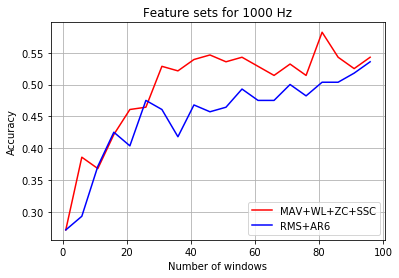

In [140]:
pylab.grid(True)
pylab.plot(x1_1000, y1_1000, 'r-', label='MAV+WL+ZC+SSC')
pylab.plot(x2_1000, y2_1000, 'b-', label='RMS+AR6')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')
pylab.legend(loc='lower right')
pylab.title('Feature sets for 1000 Hz')